# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [6]:
# Import essential libraries for data manipulation and analysis

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import random

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE 

import warnings
warnings.filterwarnings('ignore')

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [8]:
# Importing the file porter_data_1.csv

porter = pd.read_csv('porter_data_1.csv')
porter.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

In [9]:
# Check the shape of the dataframe
print(f"Total Rows are ", porter.shape[0], "\nTotal Columns are", porter.shape[1])

Total Rows are  175777 
Total Columns are 14


In [10]:
# Check the information about the columns in dataframe
porter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

### Observations
From the above, we can observe the following:
+ No **'Null'** values are present in any of the columns
  
+ **created_at** & **actual_delivery_time** - These are **time-stamps** but showing as '*object*' data type

+ **market_id** - Field description says this is an **integer** type but data type is showing as '*float64*'

+ **store_primary_category** & **order_protocol** - Field description says these are **Category** type but data type is showing as '*int64*' and '*float64*' respectively

+ **total_onshift_dashers**, **total_busy_dashers** & **total_outstanding_orders** - These are should be of **integer** type but data type is showing as '*float64*'

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [15]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

porter['created_at'] = pd.to_datetime(porter['created_at'])
porter['actual_delivery_time'] = pd.to_datetime(porter['actual_delivery_time'])

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [17]:
# Convert categorical features to category type

porter['store_primary_category'] = porter['store_primary_category'].astype('category')
porter['order_protocol'] = porter['order_protocol'].astype('category')

In [18]:
# Converting the 'float64' data to 'integer' type
for col in ['market_id', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']:
    porter[col] = porter[col].astype('int64')

In [19]:
# Checking the updated information about the columns in dataframe
porter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175777 non-null  int64         
 1   created_at                175777 non-null  datetime64[ns]
 2   actual_delivery_time      175777 non-null  datetime64[ns]
 3   store_primary_category    175777 non-null  category      
 4   order_protocol            175777 non-null  category      
 5   total_items               175777 non-null  int64         
 6   subtotal                  175777 non-null  int64         
 7   num_distinct_items        175777 non-null  int64         
 8   min_item_price            175777 non-null  int64         
 9   max_item_price            175777 non-null  int64         
 10  total_onshift_dashers     175777 non-null  int64         
 11  total_busy_dashers        175777 non-null  int64         
 12  to

In [20]:
# Stastitical information of the numeric data
porter.describe()

market_id                     created_at  \
count  175777.000000                         175777   
mean        2.743726  2015-02-04 19:57:50.009631744   
min         1.000000            2015-01-21 15:22:03   
25%         2.000000            2015-01-29 01:31:19   
50%         2.000000            2015-02-05 02:41:26   
75%         4.000000            2015-02-12 01:04:32   
max         6.000000            2015-02-18 06:00:44   
std         1.330963                            NaN   

                actual_delivery_time    total_items       subtotal  \
count                         175777  175777.000000  175777.000000   
mean   2015-02-04 20:44:02.190406144       3.204976    2697.111147   
min              2015-01-21 16:07:03       1.000000       0.000000   
25%              2015-01-29 02:16:30       2.000000    1412.000000   
50%              2015-02-05 03:34:33       3.000000    2224.000000   
75%              2015-02-12 01:48:24       4.000000    3410.000000   
max              2015-02-18 06:51:10     411.000000   26800.000000   
std                              NaN       2.674055    1828.554893   

       num_distinct_items  min_item_price  max_item_price  \
count       175777.000000   175777.000000   175777.000000   
mean             2.675060      684.965433     1160.158616   
min              1.000000      -86.000000        0.000000   
25%              1.000000      299.000000      799.000000   
50%              2.000000      595.000000     1095.000000   
75%              3.000000      942.000000     1395.000000   
max             20.000000    14700.000000    14700.000000   
std              1.625681      519.882924      560.828571   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
count          175777.000000       175777.000000             175777.000000   
mean               44.918664           41.861381                 58.230115   
min                -4.000000           -5.000000                 -6.000000   
25%                17.000000           15.000000                 17.000000   
50%                37.000000           35.000000                 41.000000   
75%                66.000000           63.000000                 85.000000   
max               171.000000          154.000000                285.000000   
std                34.544724           32.168505                 52.731043   

            distance  
count  175777.000000  
mean       21.843090  
min         0.000000  
25%        15.360000  
50%        21.760000  
75%        28.120000  
max        83.520000  
std         8.748712

### Observations
From the above, we can observe the following:
+ **subtotal**, **max_item_price** & **distance** columns are having the *min* value as *zero*, which needs a further inspection
  
+ **min_item_price**, **total_onshift_dashers**, **total_busy_dashers** & **total_outstanding_orders** are having a negative *min* value, which needs a further inspection

+ Almost all the columns *mean* and *median* values are in sync

+ Considerable deviation is visible between the *75%* data and *max* data in the columns **total_item**, **subtotal**, **num_distinct_items**, **min_item_price**, **max_item_price**, **total_onshift_dashers**, **total_busy_dashers**, **total_outstanding_orders** & **distance**

+ Even the *std* is huge times of the *max* value for the above columns

+ This indicates that there is chance of **outliers** within this data, which will be further analysed

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [24]:
# Calculate time taken in minutes
porter['delivery_duration_minutes'] = (porter['actual_delivery_time'] - porter['created_at']).dt.total_seconds()/60

print(porter['delivery_duration_minutes'])

0         47.0
1         44.0
2         55.0
3         59.0
4         46.0
          ... 
175772    43.0
175773    62.0
175774    46.0
175775    45.0
175776    37.0
Name: delivery_duration_minutes, Length: 175777, dtype: float64


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [26]:
# Extract the hour and day of week from the 'created_at' timestamp
porter['created_hour'] = porter['created_at'].dt.hour.astype('category')
porter['created_day'] = porter['created_at'].dt.day_name()

# Create a categorical feature 'isWeekend'
porter['created_is_weekend'] = porter['created_day'].apply(lambda x: 1 if x in {'Saturday', 'Sunday'} else 0).astype('category')

In [27]:
# Checking the updated data frame
porter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   market_id                  175777 non-null  int64         
 1   created_at                 175777 non-null  datetime64[ns]
 2   actual_delivery_time       175777 non-null  datetime64[ns]
 3   store_primary_category     175777 non-null  category      
 4   order_protocol             175777 non-null  category      
 5   total_items                175777 non-null  int64         
 6   subtotal                   175777 non-null  int64         
 7   num_distinct_items         175777 non-null  int64         
 8   min_item_price             175777 non-null  int64         
 9   max_item_price             175777 non-null  int64         
 10  total_onshift_dashers      175777 non-null  int64         
 11  total_busy_dashers         175777 non-null  int64   

In [28]:
# Drop unnecessary columns
porter.drop(['created_at', 'actual_delivery_time', 'created_day'], axis =1, inplace = True)

# Checking columns in updated dataframe
porter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   market_id                  175777 non-null  int64   
 1   store_primary_category     175777 non-null  category
 2   order_protocol             175777 non-null  category
 3   total_items                175777 non-null  int64   
 4   subtotal                   175777 non-null  int64   
 5   num_distinct_items         175777 non-null  int64   
 6   min_item_price             175777 non-null  int64   
 7   max_item_price             175777 non-null  int64   
 8   total_onshift_dashers      175777 non-null  int64   
 9   total_busy_dashers         175777 non-null  int64   
 10  total_outstanding_orders   175777 non-null  int64   
 11  distance                   175777 non-null  float64 
 12  delivery_duration_minutes  175777 non-null  float64 
 13  created_hour  

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [31]:
# Define target variable (y) and features (X)

# Target Variable
y = porter['delivery_duration_minutes']

# Feature variables
X = porter.drop(['delivery_duration_minutes'], axis =1)

y, X


(0         47.0
 1         44.0
 2         55.0
 3         59.0
 4         46.0
           ... 
 175772    43.0
 175773    62.0
 175774    46.0
 175775    45.0
 175776    37.0
 Name: delivery_duration_minutes, Length: 175777, dtype: float64,
         market_id store_primary_category order_protocol  total_items  \
 0               1                      4            1.0            4   
 1               2                     46            2.0            1   
 2               2                     36            3.0            4   
 3               1                     38            1.0            1   
 4               1                     38            1.0            2   
 ...           ...                    ...            ...          ...   
 175772          1                     28            4.0            3   
 175773          1                     28            4.0            6   
 175774          1                     28            4.0            5   
 175775          1          

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [33]:
# Split data into training and testing sets
porter_train, porter_test = train_test_split (porter, train_size = 0.8, random_state = 50)
print(f'Train Shape Size is', porter_train.shape, '\nTest Shape Size is', porter_test.shape)

Train Shape Size is (140621, 15) 
Test Shape Size is (35156, 15)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [36]:
# Define numerical and categorical columns for easy EDA and data manipulation

# Numerical Variables
porter_train_num = porter_train.select_dtypes(include = ['int64', 'float64']).columns
print(porter_train_num)

Index(['market_id', 'total_items', 'subtotal', 'num_distinct_items',
       'min_item_price', 'max_item_price', 'total_onshift_dashers',
       'total_busy_dashers', 'total_outstanding_orders', 'distance',
       'delivery_duration_minutes'],
      dtype='object')


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

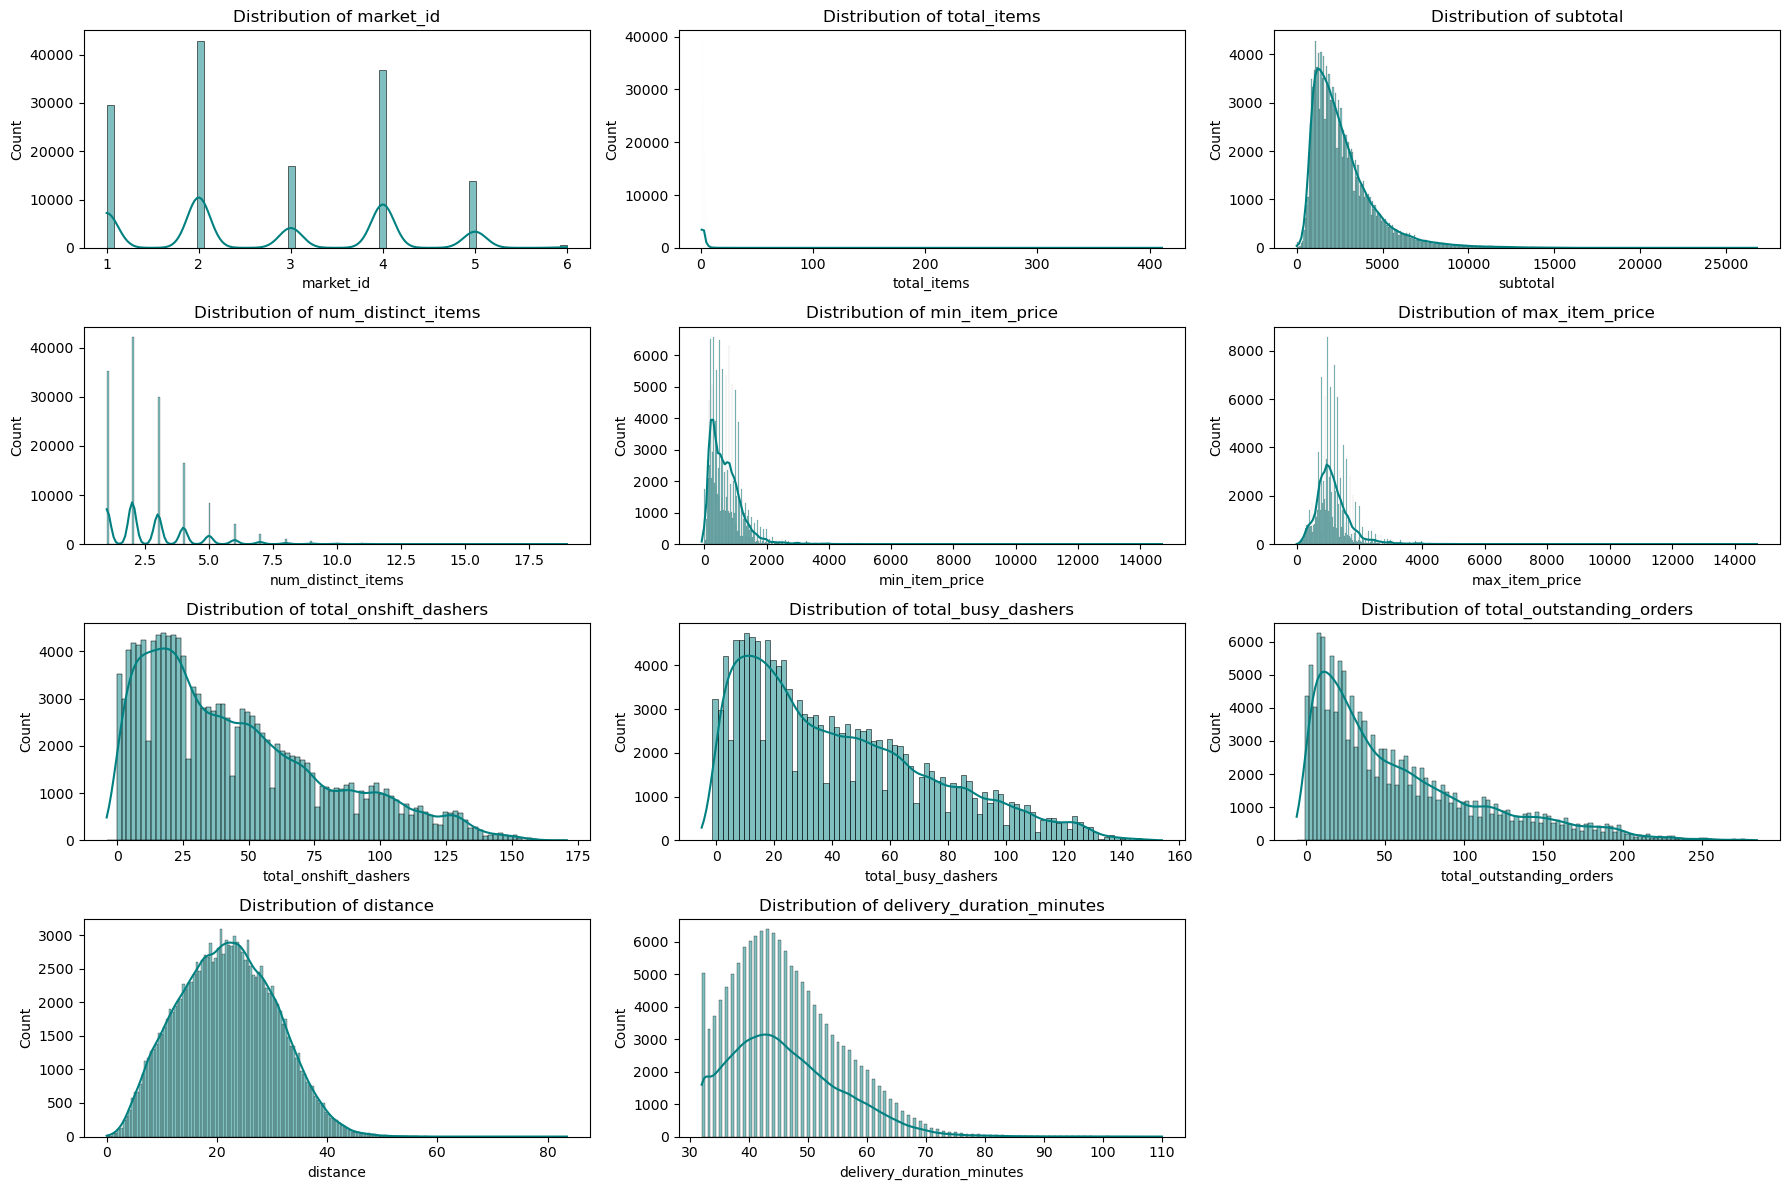

In [38]:
# Plot distributions for all numerical columns
plt.figure(figsize=(18, 12))
for i, col in enumerate(porter_train_num, 1):
    plt.subplot(4, 3, i)
    sns.histplot(porter_train[col], kde=True, color='teal')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

In [40]:
# Categorical Variables
porter_train_cat = porter_train.select_dtypes(include = ['category', 'object']).columns
print(porter_train_cat)

Index(['store_primary_category', 'order_protocol', 'created_hour',
       'created_is_weekend'],
      dtype='object')


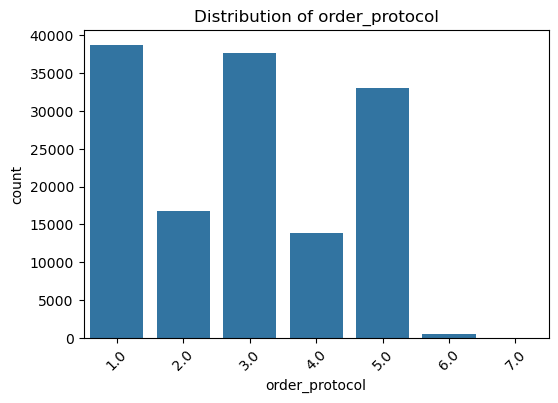

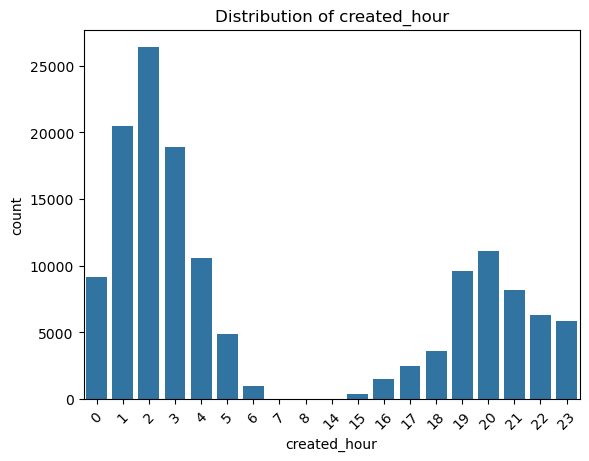

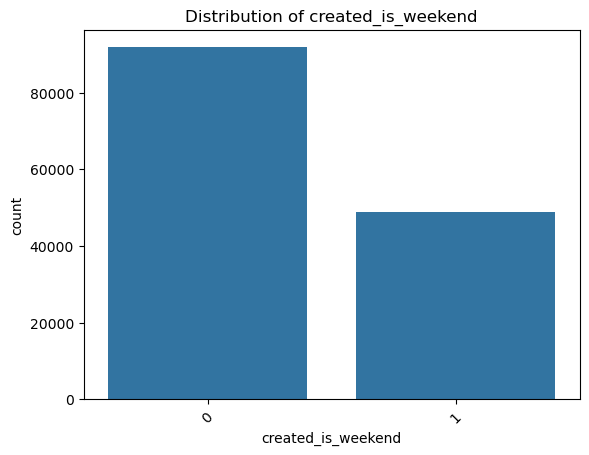

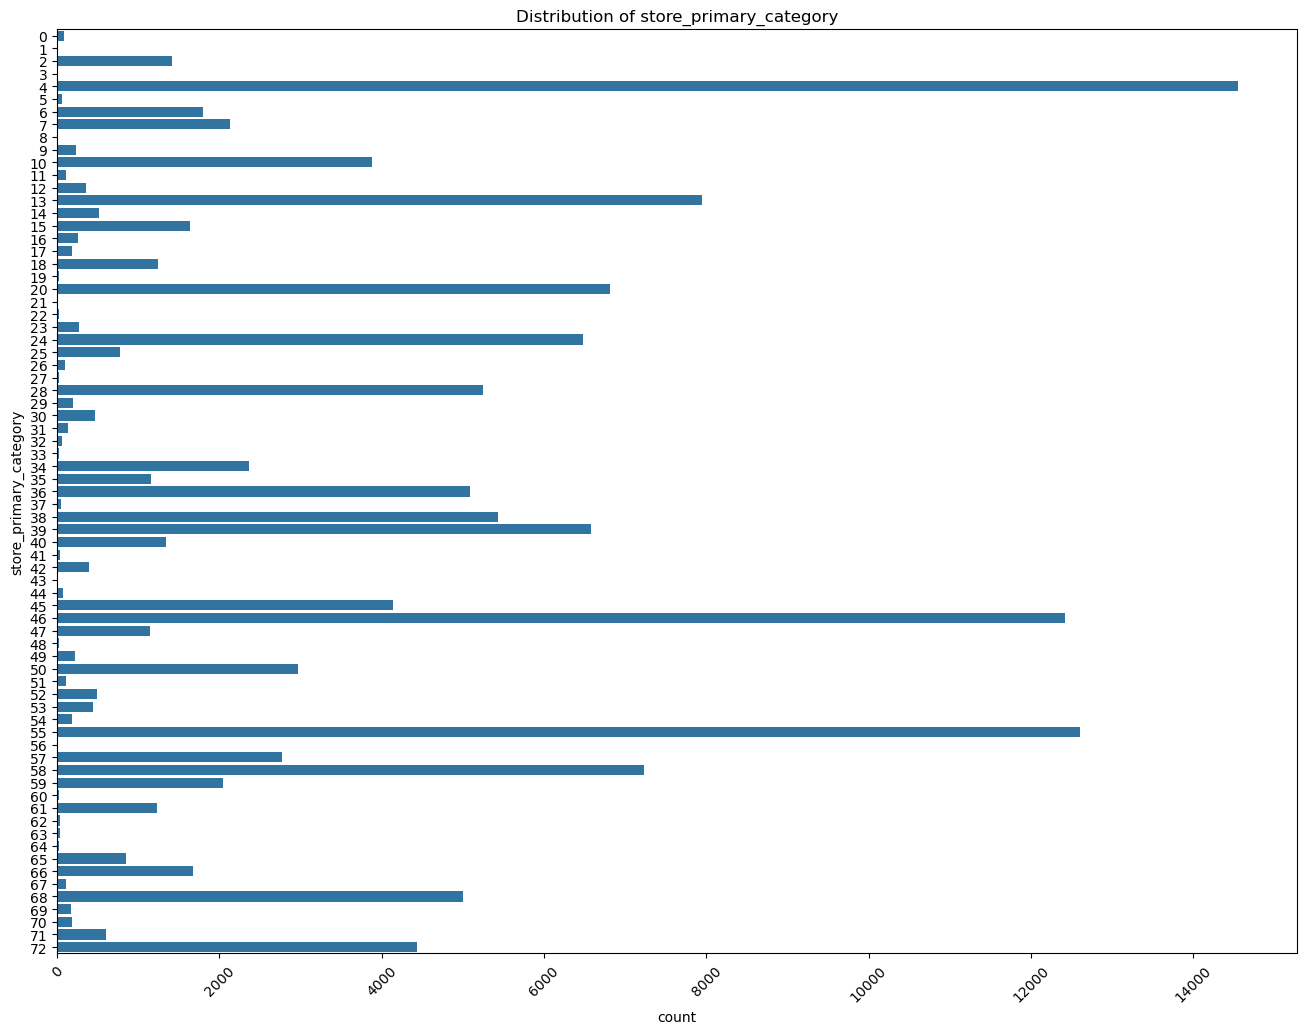

In [41]:
# Distribution of categorical columns

# All categories excluding 'store_primary_category'
plt.figure(figsize=(6, 4))
for col in (porter_train_cat.drop('store_primary_category')):
    sns.countplot(data=porter_train, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

# Category 'store_primary_category'
plt.figure(figsize=(16, 12))
#porter_train_cat['store_primary_category']
sns.countplot(data=porter_train['store_primary_category'])
plt.title(f'Distribution of store_primary_category')
plt.xticks(rotation=45)
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

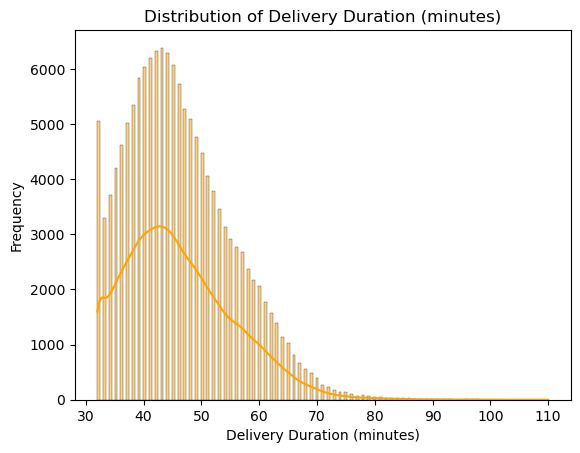

In [43]:
# Distribution of time_taken

sns.histplot(porter_train['delivery_duration_minutes'], kde=True, color='orange')
plt.title('Distribution of Delivery Duration (minutes)')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

### Observations
+ The distribution of delivery_duration_minutes is right-skewed, indicating that most deliveries take between 35 to 55 minutes, with the highest frequency around 45 minutes.

+ A long tail is observed beyond 60-70 minutes, where deliveries take unusually longer—potential indicators of outliers or special cases like traffic, unavailability of dashers, etc.,

+ The density curve confirms the skewed shape and supports the observation that the central tendency lies below 50 minutes.

+ This distribution suggests further statistical treatment like transformation, outlier clipping, etc., before model training.

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

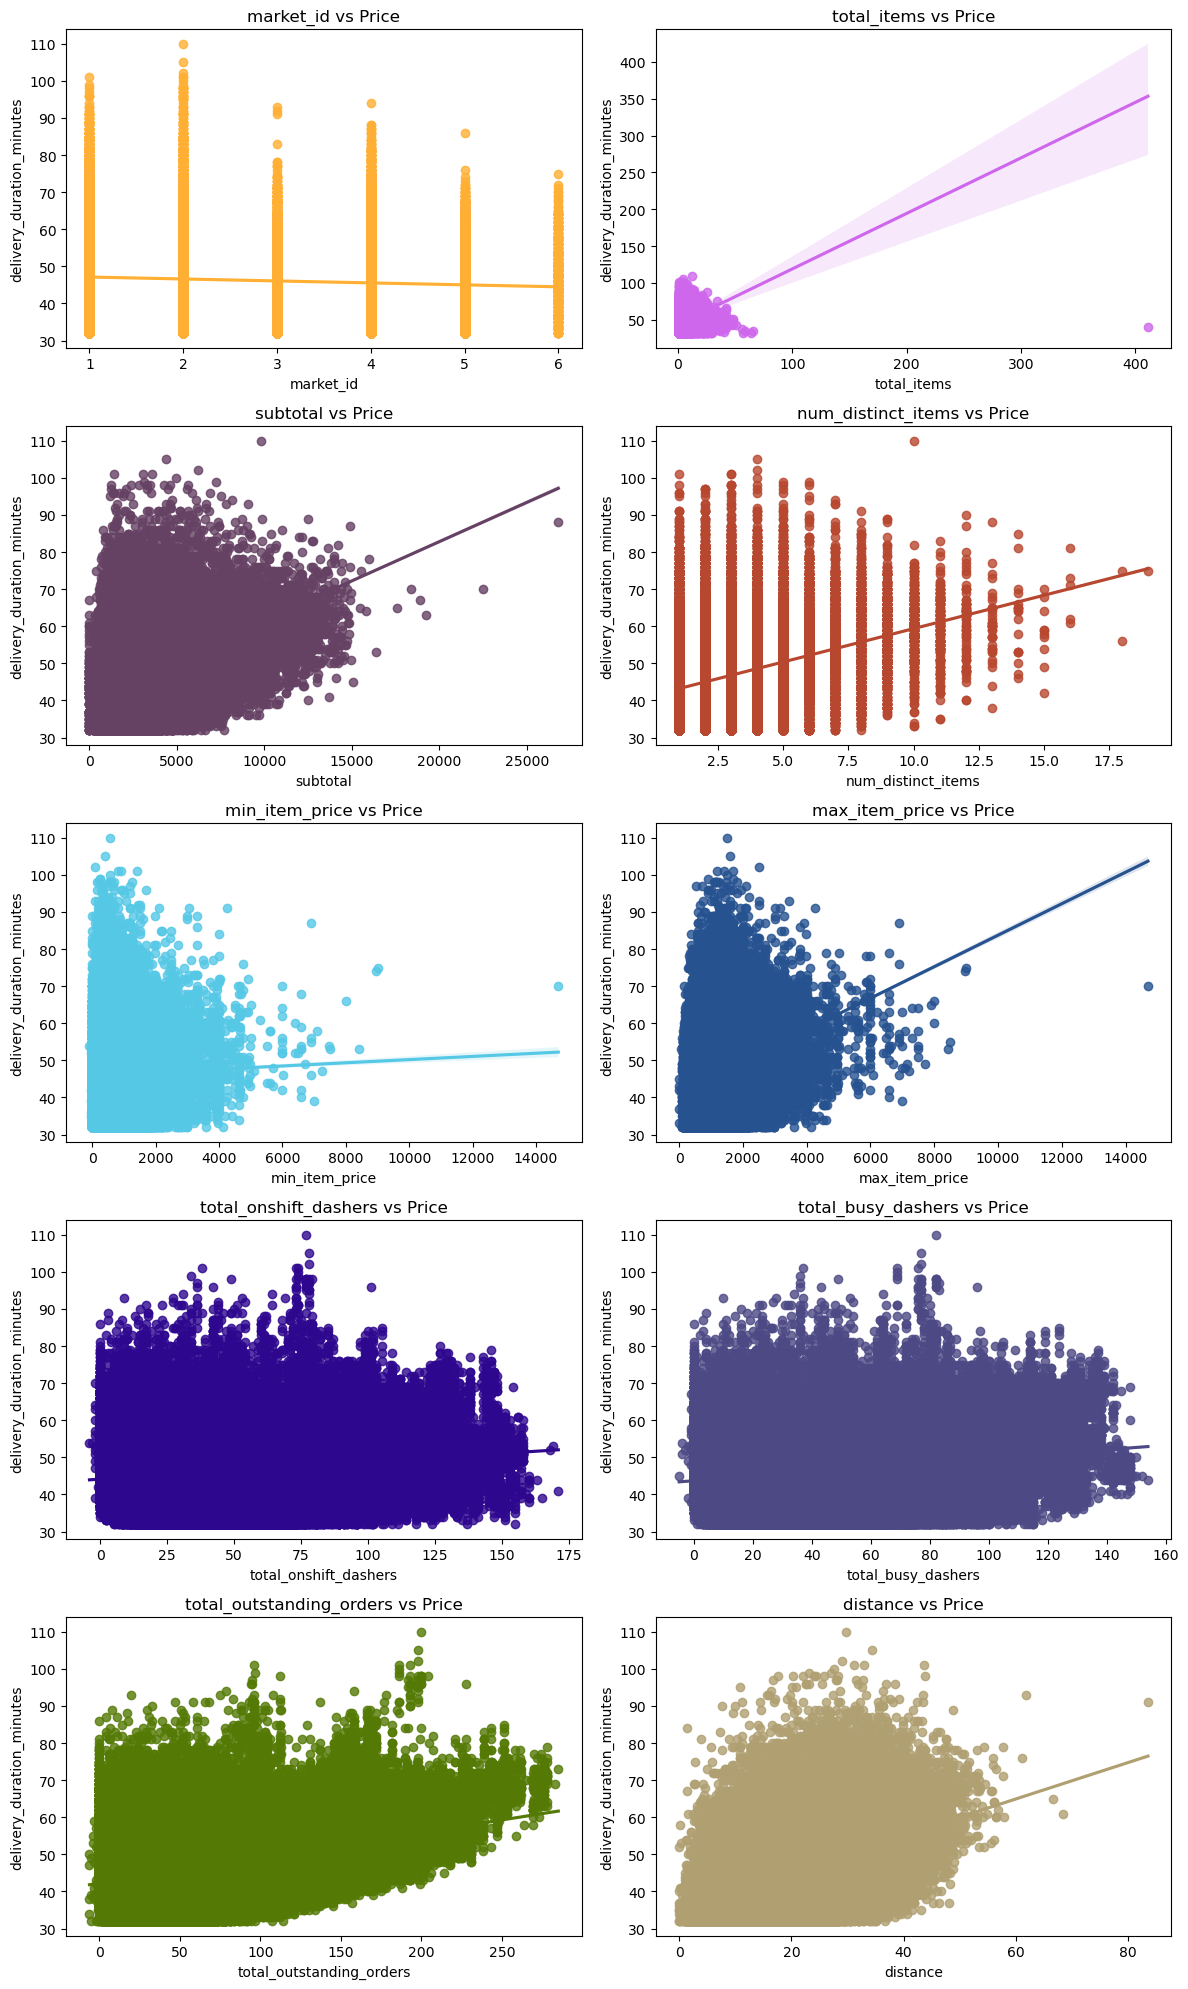

In [47]:
# Scatter plot to visualise the relationship between time_taken and other features

# Relationship between time_taken and all numerical columns

features_num = porter_train_num.drop('delivery_duration_minutes')
n = len(features_num)

ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(
                        nrows = nrows, 
                        ncols = ncols, 
                        figsize = (6*ncols, 4*nrows)
                        )
axes = axes.flatten()

def random_color():
    return to_hex(np.random.rand(3,))

for i, col in enumerate(features_num):
    color = random_color()
    ax = axes[i]
    sns.regplot(
                x = col, 
                y = 'delivery_duration_minutes', 
                data = porter_train, 
                ax = ax,
                scatter_kws = {'color': color}, 
                line_kws = {'color': color}
                )
    ax.set_title(f'{col} vs Price')
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Observations
+ **total_items**, **min_item_price**, **max_item_price**, **sub_total** & **distance** scatterplots evidently shows have several extreme values (high-end outliers). These may distort model predictions and must be either removed, capped, or transformed (e.g., log scale).

+ **total_onshift_dashers**, **total_busy_dashers** & **total_outstanding_orders** scatterplots o	Display a stable distribution of points with no major skew or visible anomalies. These can likely be retained without major transformations


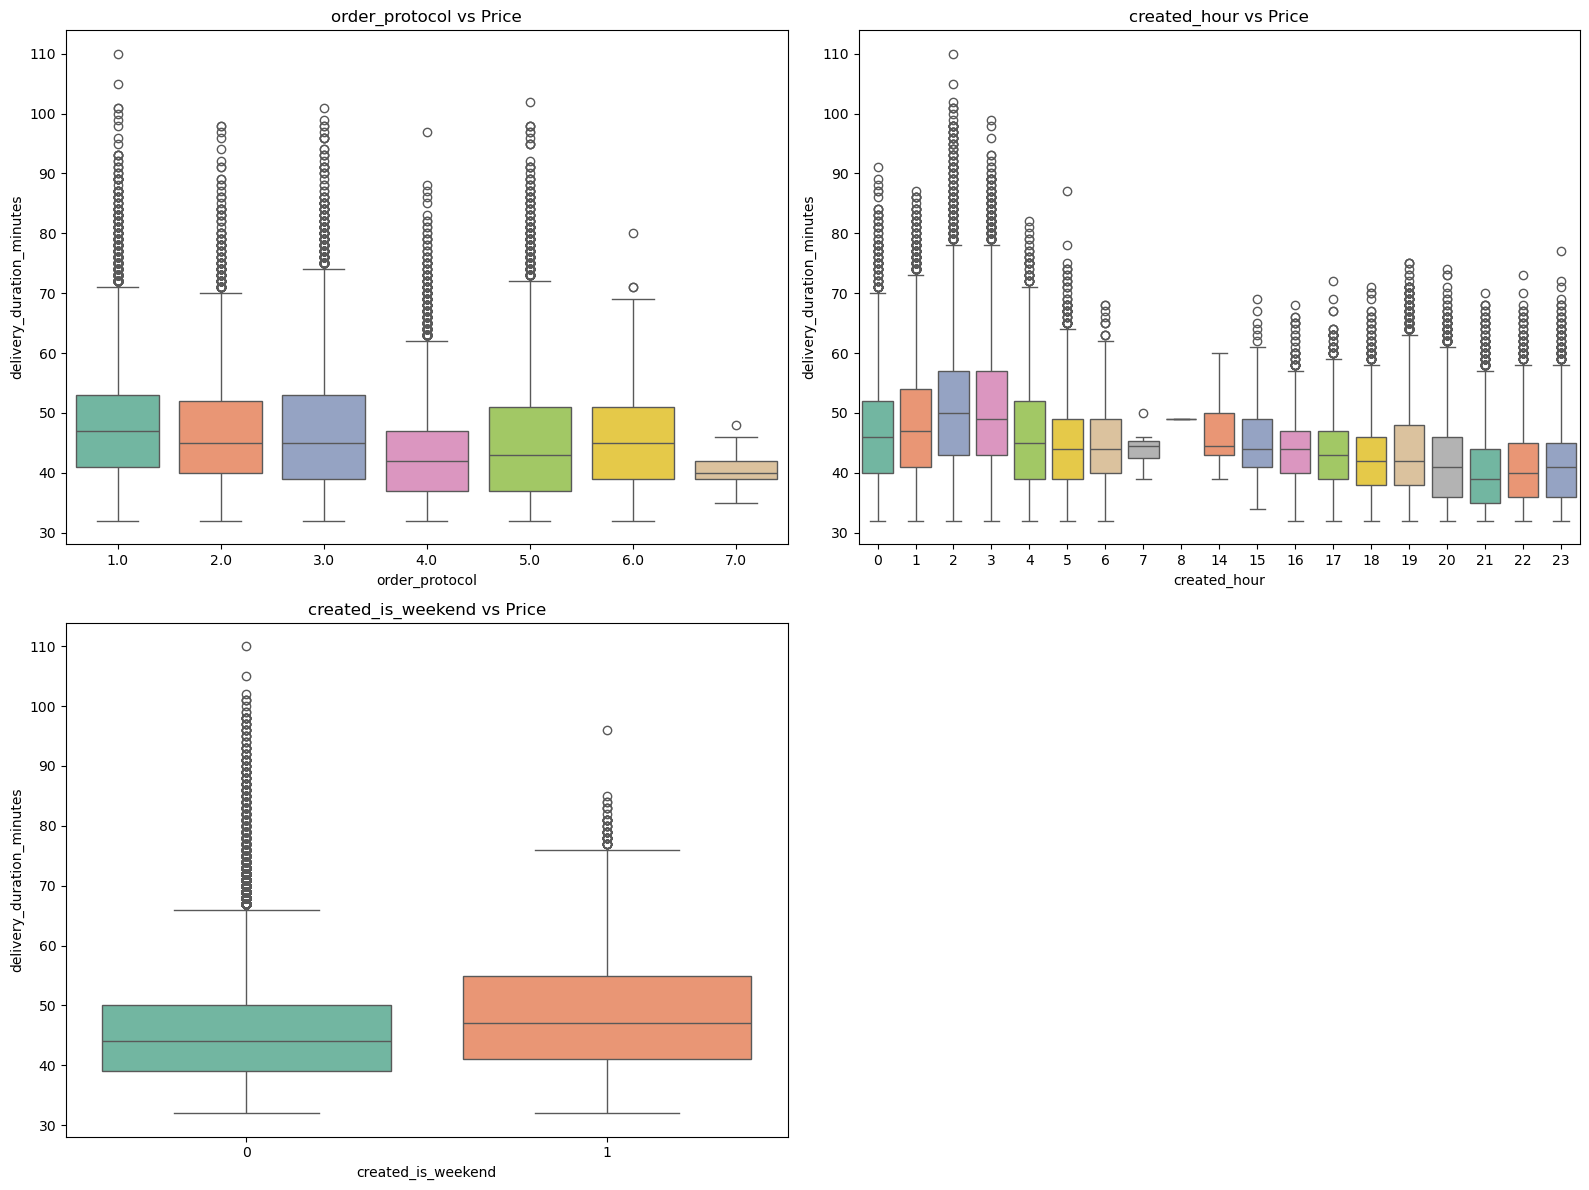

In [237]:
# relationship between time_taken and categorical columns

# All categories excluding 'store_primary_category'
features_cat = porter_train_cat.drop('store_primary_category')
fig, axes = plt.subplots(
                        nrows = 2, 
                        ncols = 2, 
                        figsize = (16, 12)
                        )
axes = axes.flatten()

def random_color():
    return to_hex(np.random.rand(3,))

for i, col in enumerate(features_cat):
    color = random_color()
    ax = axes[i]
    sns.boxplot(
                x = col, 
                y = 'delivery_duration_minutes', 
                data = porter_train, 
                ax = ax, 
                palette = 'Set2'
                )
    ax.set_title(f'{col} vs Price')
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


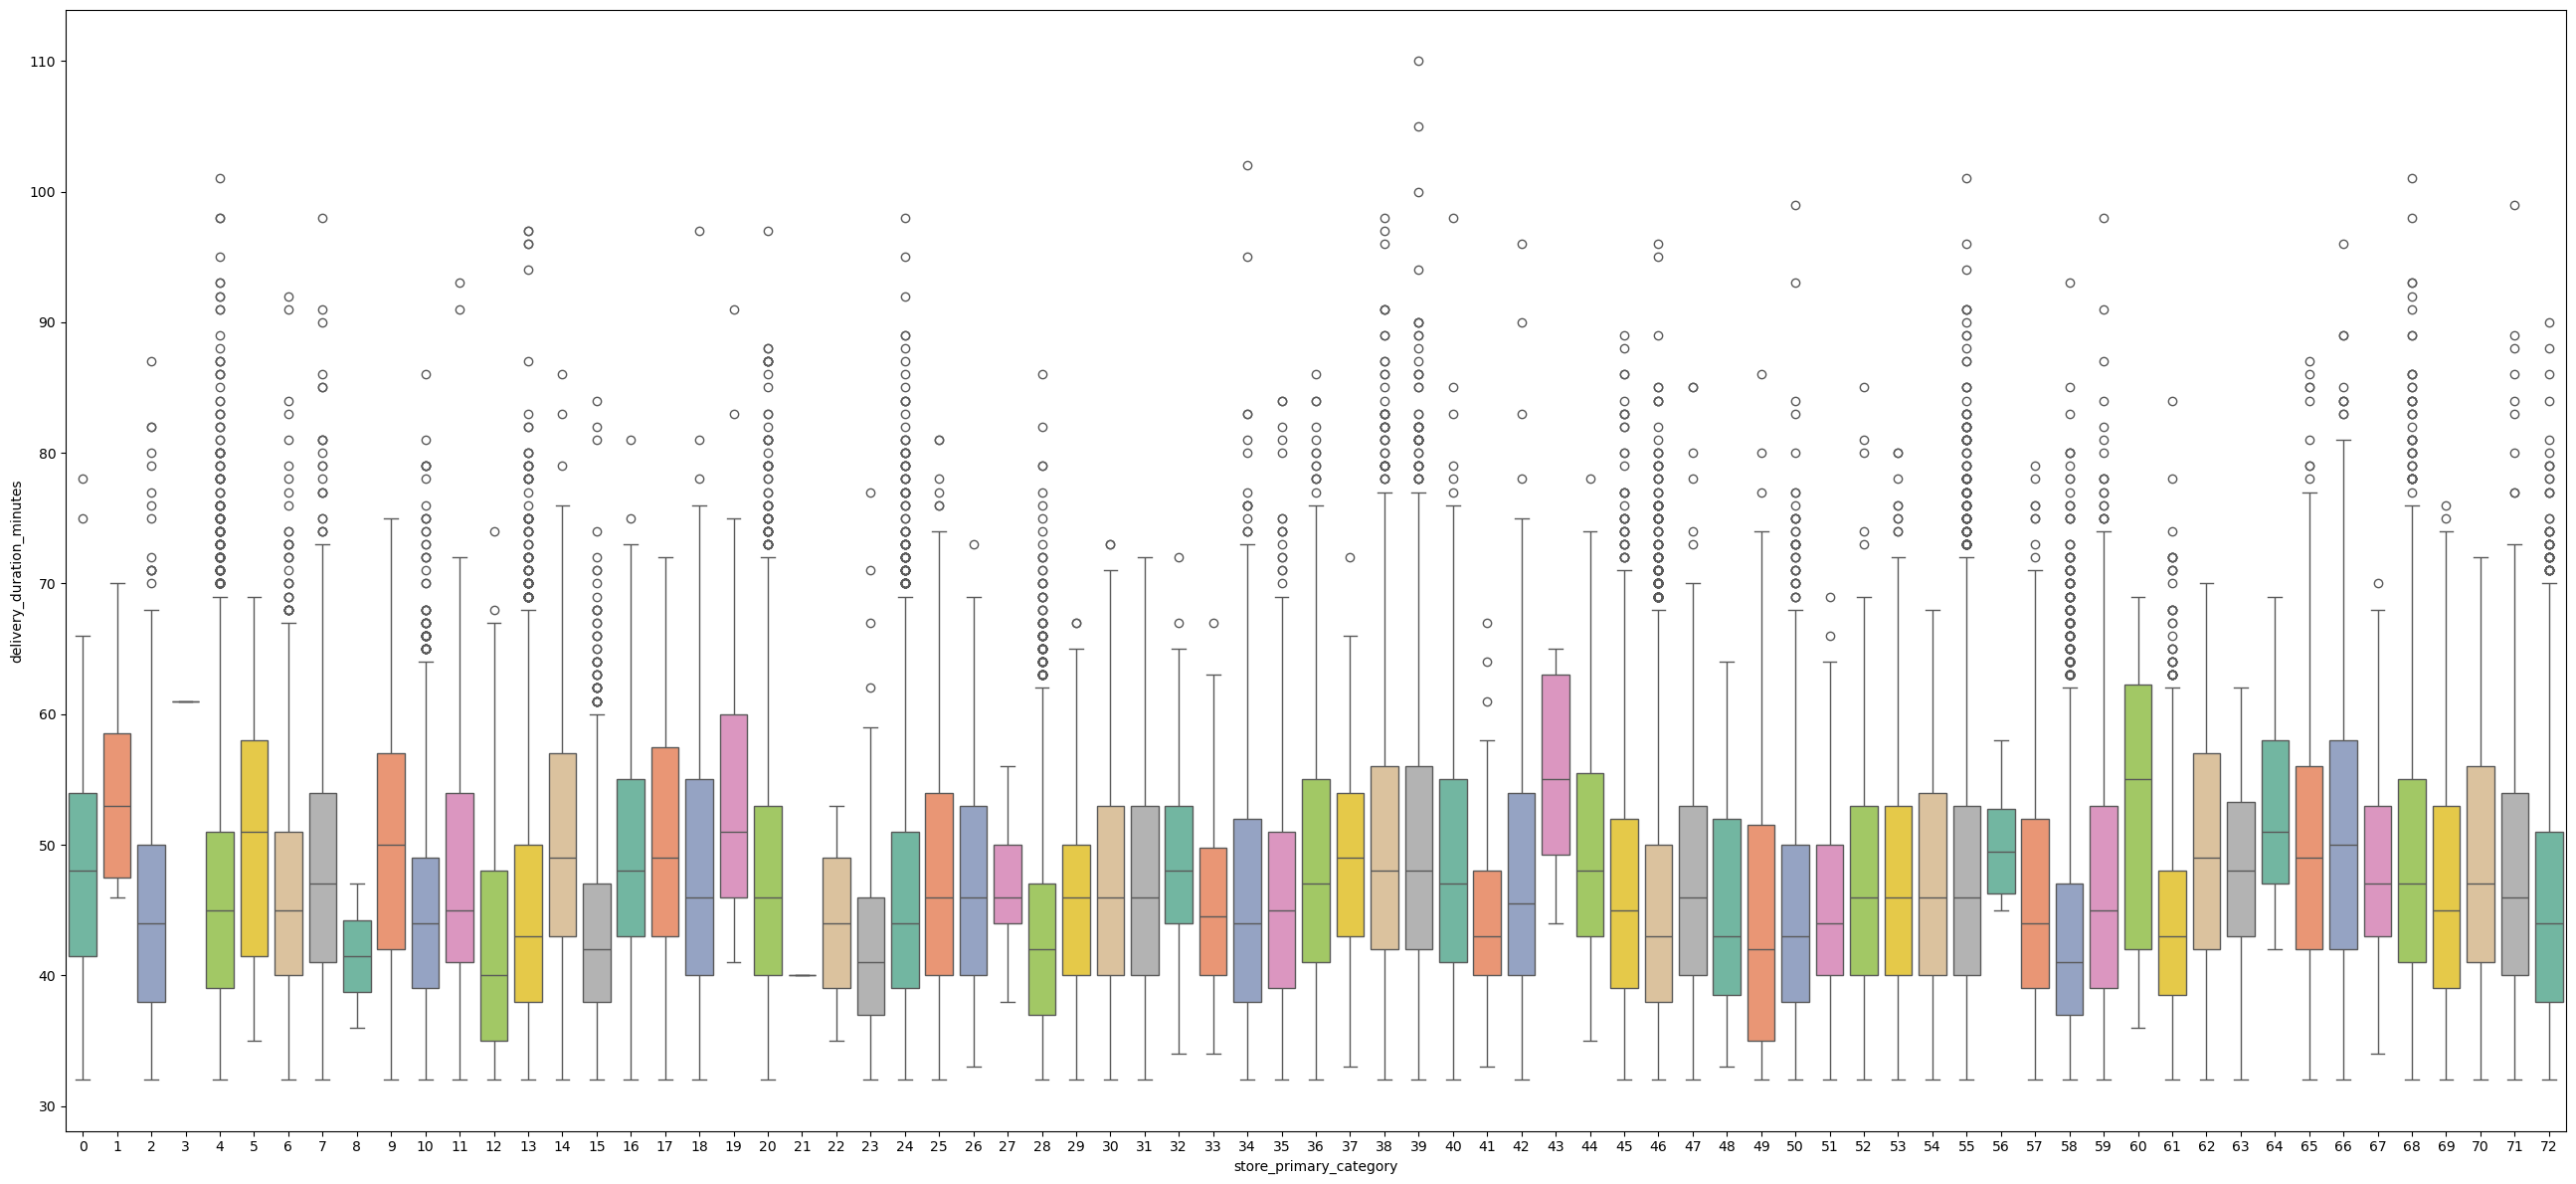

In [239]:
# Category 'store_primary_category'
fig = plt.figure(figsize=(26, 12))
axes = axes.flatten()
color = random_color()
sns.boxplot(
            x = 'store_primary_category', 
            y = 'delivery_duration_minutes', 
            data = porter_train, 
            palette = 'Set2'
            )
ax.set_title(f'store_primary_category vs Price')
plt.tight_layout()
plt.show()

### Observations
+ **created_day** & **Created_is_weekend** boxplots indicates that Weekends and Mondays see higher delivery durations (possibly due to more traffic, staff shortages, or higher order volumes). Weekdays (especially Wednesday & Thursday) show lower medians in delivery duration, suggesting faster turnarounds.

+ **order_protocol** boxplot shows that Protocols 4 and 7 appear to have lower medians and tighter interquartile ranges (IQRs), possibly indicating more efficient handling. Some protocols show higher variability, indicating inconsistency

+ **created_hour** o	Order volume spikes between 00:00–05:00 hrs suggest high demand late at night or early morning. A noticeable lean period between 07:00–14:00 hrs, which might affect staffing or delivery speed.

+ **store_primary_category** boxplot shows that Most categories have comparable delivery durations. A few outliers exist, but the central tendency across store types is relatively uniform. Categories with wide IQR or many outliers may require further segmentation or special handling


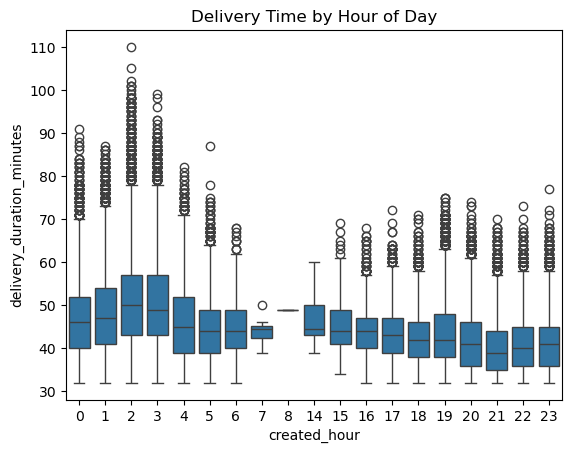

In [51]:
# Show the distribution of time_taken for different hours

sns.boxplot(x='created_hour', y='delivery_duration_minutes', data=porter_train)
plt.title('Delivery Time by Hour of Day')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

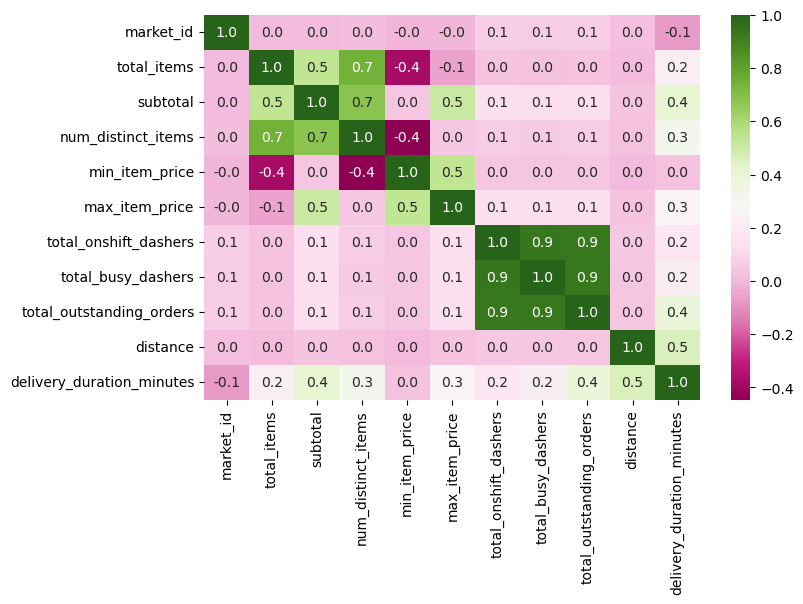

In [54]:
# Plot the heatmap of the correlation matrix

plt.figure(figsize = (8,5))
sns.heatmap(
    porter_train[porter_train_num].corr(), 
    annot = True, 
    fmt = ".1f", 
    cmap = 'PiYG'
)
plt.show()


### Observation
+ **total_onshift_dashers**, **total_busy_dashers** & **total_oustanding_orders** are having very very high positive correaltion as expected
  
+  **total_items**, **subtotal** & **num_distinct_items** are having very high positive correaltion, might be due to the dependency

+  **delivery_duration_minutes** is having high positive correlation with distance, as obvious, and positive correlation with all other features except **market_id**, surprisingly - this needs a further investigation

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [57]:
# Drop 3-5 weakly correlated columns from training dataset
porter_train_new = porter_train.drop(['market_id', 'min_item_price', 'num_distinct_items'], axis = 1)
porter_train_new.head()

store_primary_category order_protocol  total_items  subtotal  \
92179                      14            2.0            3      3600   
172804                     58            3.0            4      1458   
67246                      71            1.0            2      2590   
38049                      69            3.0            1      1050   
151202                      6            2.0            6      2875   

        max_item_price  total_onshift_dashers  total_busy_dashers  \
92179             1400                     40                  39   
172804             400                     38                  55   
67246             1295                     60                  60   
38049             1050                      2                   3   
151202             450                     61                  54   

        total_outstanding_orders  distance  delivery_duration_minutes  \
92179                         70     30.12                       59.0   
172804                        49     21.52                       37.0   
67246                         69     18.68                       43.0   
38049                          3     22.60                       41.0   
151202                        64     29.64                       40.0   

       created_hour created_is_weekend  
92179             3                  0  
172804           19                  0  
67246             3                  0  
38049            19                  0  
151202           21                  0

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

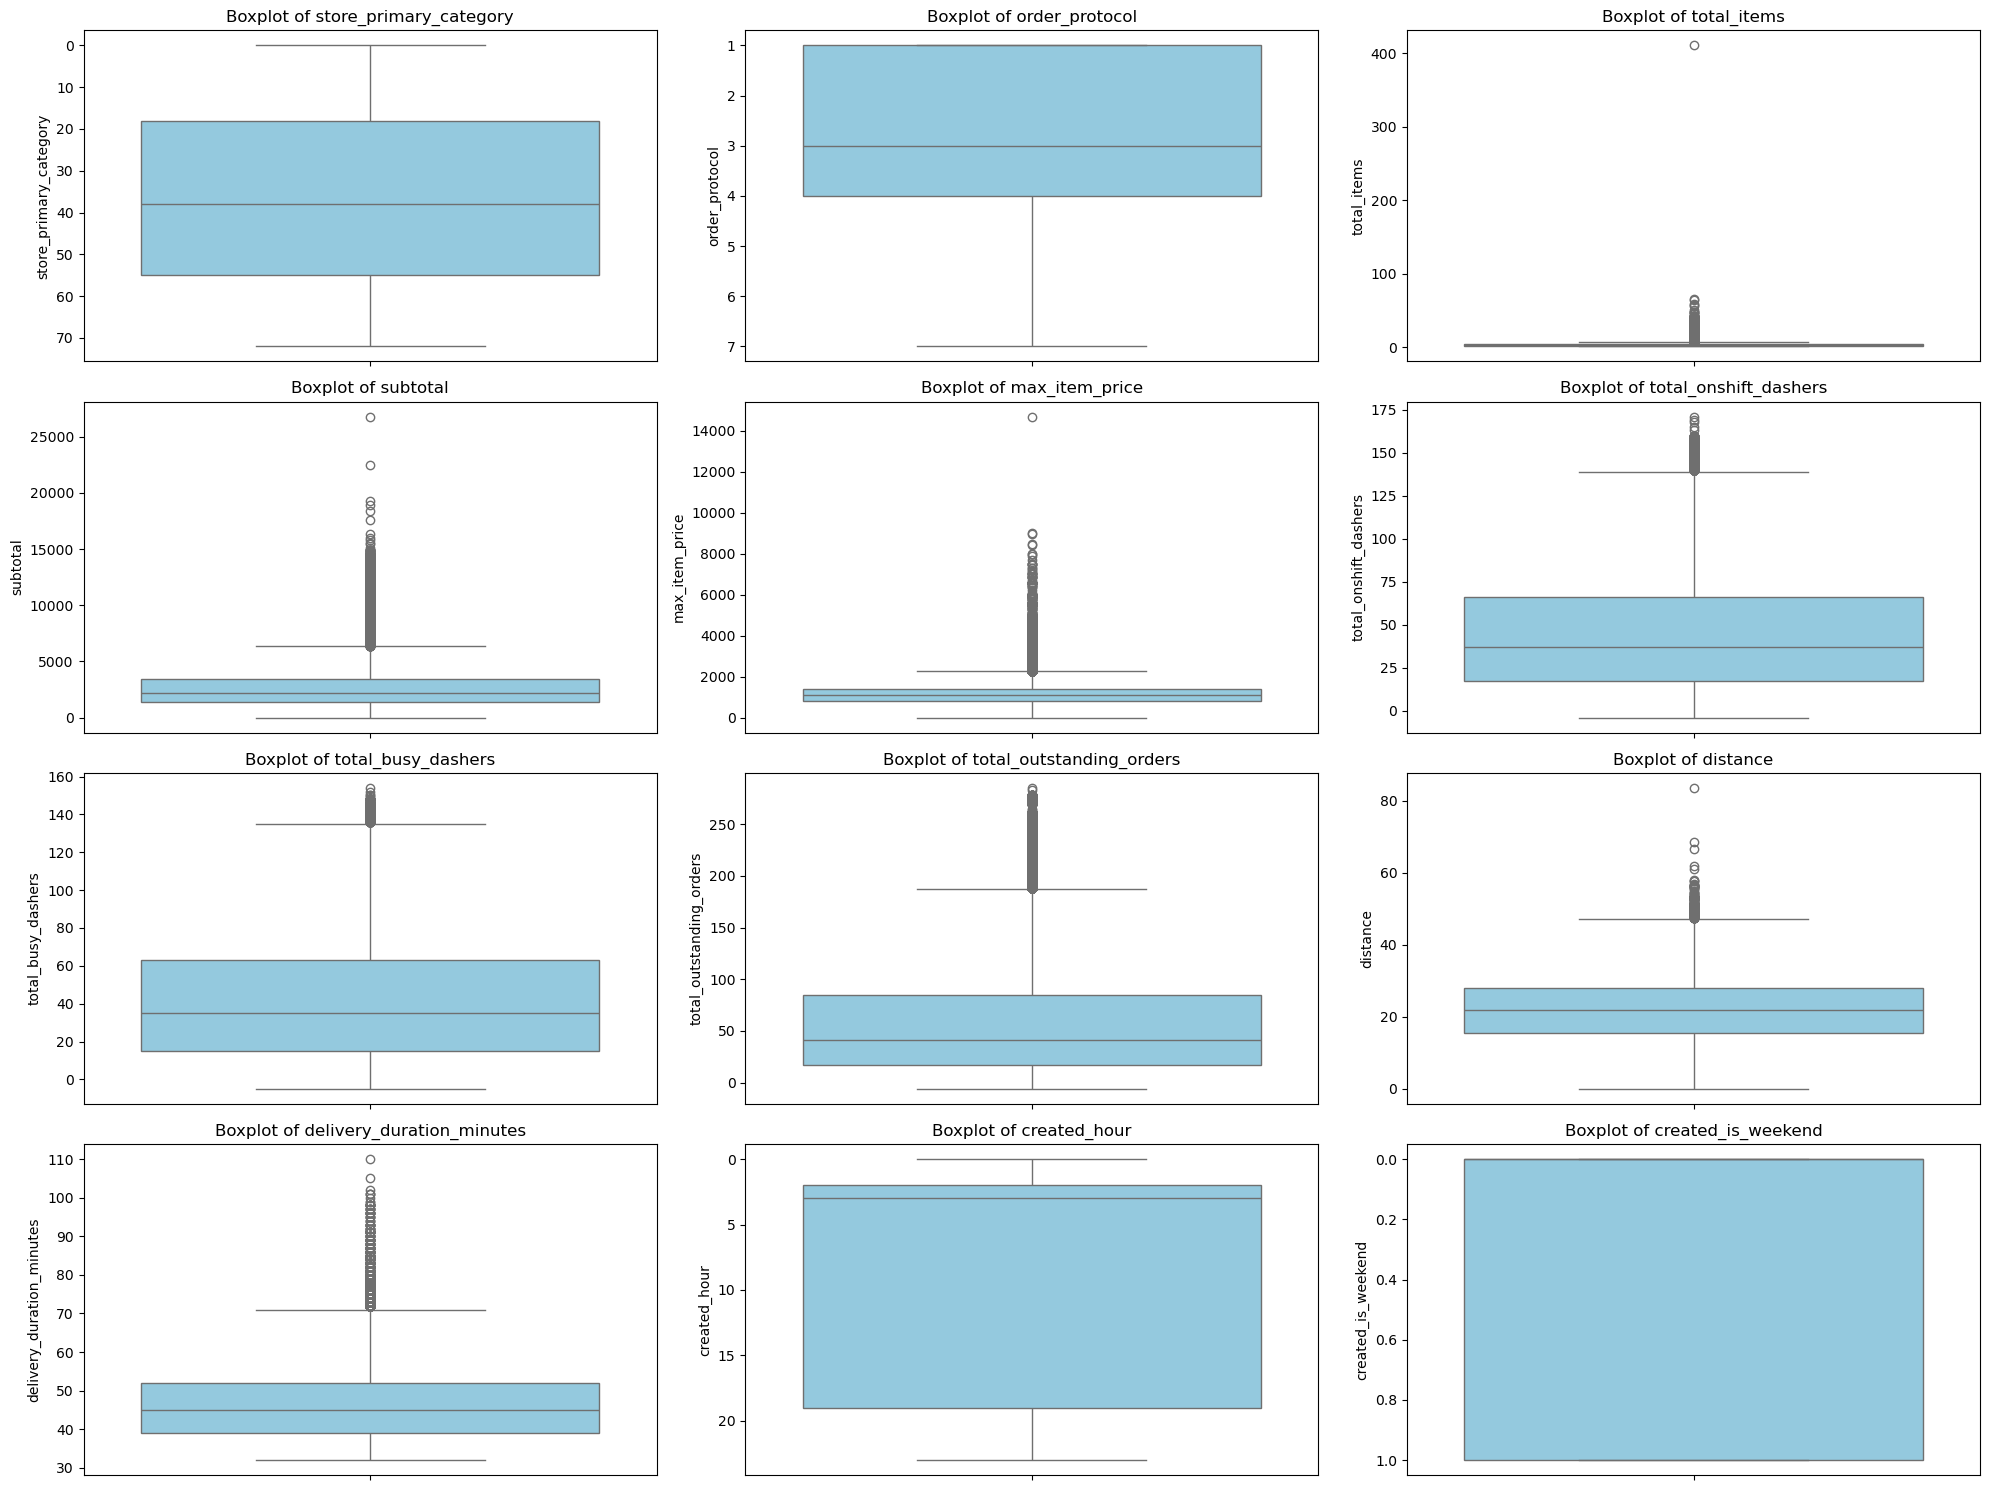

In [60]:
# Boxplot for time_taken

plt.figure(figsize=(20, 15))
for i, col in enumerate(porter_train_new, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=porter_train_new[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

### Observations:
+ **delivery_duration_minutes**, **total_items**, **subtotal**, and **distance** clearly show high-end outliers.

+ Dasher-related columns like **total_onshift_dashers**, **total_busy_dashers**, and **total_outstanding_orders** have some mild outliers but are mostly centered.

+ **max_item_price** has a few visible outliers that might represent premium order cases.

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [63]:
# Reverify the stastitical features of numerical variables
num_cols = porter_train_new.select_dtypes(include=['int64', 'float64']).columns
porter_train_new[num_cols].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]).T.round(2)

count     mean      std   min      25%      50%  \
total_items                140621.0     3.20     2.73   1.0     2.00     3.00   
subtotal                   140621.0  2692.47  1824.96   0.0  1400.00  2219.00   
max_item_price             140621.0  1159.38   562.60   0.0   799.00  1095.00   
total_onshift_dashers      140621.0    44.92    34.57  -4.0    17.00    37.00   
total_busy_dashers         140621.0    41.85    32.19  -5.0    15.00    35.00   
total_outstanding_orders   140621.0    58.23    52.77  -6.0    17.00    41.00   
distance                   140621.0    21.84     8.74   0.0    15.36    21.76   
delivery_duration_minutes  140621.0    46.20     9.33  32.0    39.00    45.00   

                               75%      90%      95%       max  
total_items                   4.00     6.00     7.00    411.00  
subtotal                   3400.00  4964.00  6260.00  26800.00  
max_item_price             1395.00  1795.00  2100.00  14700.00  
total_onshift_dashers        66.00    98.00   115.00    171.00  
total_busy_dashers           63.00    90.00   105.00    154.00  
total_outstanding_orders     85.00   140.00   169.00    285.00  
distance                     28.12    33.32    36.28     83.52  
delivery_duration_minutes    52.00    59.00    63.00    110.00

### Observations
+ Variables like **subtotal**, **max_item_price**, and **distance** are not expected to have zero values under normal operational logic. The presence of such records indicates potential data entry or extraction errors. These records should be isolated and reviewed before making decisions on exclusion or imputation.

+ Similarly, negative values in **total_onshift_dashers**, **total_busy_dashers**, and **total_outstanding_orders** are not logically acceptable, as counts cannot be negative. These too warrant immediate verification and likely removal to prevent statistical distortion.

+ Across almost all numerical features, the maximum values differ drastically from the 95th percentile. This suggests the presence of extreme outliers, likely rare operational edge cases or erroneous data points. These should be validated further to decide whether to treat, cap, or remove.

In [65]:
# Rows with invalid values
invalid_rows = porter_train_new[
    (porter_train_new['subtotal'] <= 0) |
    (porter_train_new['max_item_price'] <= 0) |
    (porter_train_new['distance'] <= 0) |
    (porter_train_new['total_onshift_dashers'] <= 0) |
    (porter_train_new['total_busy_dashers'] <= 0) |
    (porter_train_new['total_outstanding_orders'] <= 0)
]

# Checking how many such records exists
print(f"Invalid rows found: {invalid_rows.shape[0]}")


Invalid rows found: 3635


**I found 3,635 invalid records where one or more key variables had a value of zero — this accounts for approximately 2.58% of the dataset. While the proportion is relatively small, the presence of such unrealistic values can significantly affect the model’s reliability. Hence, I considered it important to remove them to maintain data quality and integrity.**

In [67]:
# Deleting the anomoly records
porter_train_cleaned = porter_train_new.drop(invalid_rows.index)
print(f"New dataset shape: {porter_train_cleaned.shape}")

New dataset shape: (136986, 12)


In [68]:
# Reverify the stastitical features of numerical variables
porter_train_cleaned[num_cols].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]).T.round(2)

count     mean      std     min      25%  \
total_items                136986.0     3.20     2.73    1.00     2.00   
subtotal                   136986.0  2702.15  1825.13  100.00  1420.00   
max_item_price             136986.0  1162.89   562.36   52.00   799.00   
total_onshift_dashers      136986.0    46.05    34.27    1.00    18.00   
total_busy_dashers         136986.0    42.92    31.90    1.00    16.00   
total_outstanding_orders   136986.0    59.72    52.61    1.00    19.00   
distance                   136986.0    21.85     8.73    0.12    15.36   
delivery_duration_minutes  136986.0    46.11     9.34   32.00    39.00   

                               50%      75%      90%      95%       max  
total_items                   3.00     4.00     6.00     7.00    411.00  
subtotal                   2230.00  3417.00  4975.00  6274.00  26800.00  
max_item_price             1095.00  1395.00  1795.00  2100.00  14700.00  
total_onshift_dashers        38.00    67.00    99.00   115.00    171.00  
total_busy_dashers           36.00    63.00    91.00   106.00    154.00  
total_outstanding_orders     43.00    87.00   142.00   170.00    285.00  
distance                     21.76    28.12    33.32    36.28     83.52  
delivery_duration_minutes    45.00    52.00    59.00    63.00    110.00

After eliminating invalid rows, I reassessed the dataset’s numerical features using an extended 7-point summary (including the 90th and 95th percentiles).

It became evident that several features — especially subtotal, max_item_price, total_outstanding_orders, and distance — showed significant gaps between the 95th percentile and the maximum value. 

These large gaps are strong indicators of potential outliers that could distort model training. 

Hence, I planned to apply outlier treatment, such as IQR-based capping, to reduce their undue influence while retaining the overall data distribution.

In [70]:
print(porter_train_cleaned['total_items'].sort_values(ascending=False))
print(porter_train_cleaned['subtotal'].sort_values(ascending=False))
print(porter_train_cleaned['max_item_price'].sort_values(ascending=False))
print(porter_train_cleaned['distance'].sort_values(ascending=False))

41993     411
162396     66
162392     64
66980      59
13285      57
         ... 
46265       1
8631        1
121770      1
31694       1
111588      1
Name: total_items, Length: 136986, dtype: int64
167615    26800
85571     22500
64746     19250
152562    18920
7992      18370
          ...  
20887       149
76073       149
66235       145
119735      139
1689        100
Name: subtotal, Length: 136986, dtype: int64
124208    14700
41724      8999
174130     8959
14978      8500
80593      8415
          ...  
38033        99
15064        85
102904       75
18000        60
68513        52
Name: max_item_price, Length: 136986, dtype: int64
7111      83.52
25083     68.44
35651     66.68
7097      61.88
7102      61.00
          ...  
115395     0.16
20577      0.12
126621     0.12
66640      0.12
150597     0.12
Name: distance, Length: 136986, dtype: float64


In [71]:
# Rows with outlier values
outlier_rows = porter_train_new[
    (porter_train_new['total_items'] >= 400) |
    (porter_train_new['subtotal'] >= 15000) |
    (porter_train_new['max_item_price'] >= 8000)
]

# Checking how many such records exists
print(f"Invalid rows found: {outlier_rows.shape[0]}")

Invalid rows found: 18


In [72]:
# Deleting the anomoly records
porter_train_cleaned_2 = porter_train_cleaned.drop(outlier_rows.index)
print(f"New dataset shape: {porter_train_cleaned_2.shape}")

New dataset shape: (136968, 12)


In [73]:
# Reverify the stastitical features of numerical variables
porter_train_cleaned_2[num_cols].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]).T.round(2)

count     mean      std     min      25%  \
total_items                136968.0     3.20     2.50    1.00     2.00   
subtotal                   136968.0  2700.53  1818.65  100.00  1420.00   
max_item_price             136968.0  1162.48   559.57   52.00   799.00   
total_onshift_dashers      136968.0    46.05    34.27    1.00    18.00   
total_busy_dashers         136968.0    42.92    31.89    1.00    16.00   
total_outstanding_orders   136968.0    59.72    52.61    1.00    19.00   
distance                   136968.0    21.85     8.73    0.12    15.36   
delivery_duration_minutes  136968.0    46.11     9.34   32.00    39.00   

                               50%      75%      90%      95%       max  
total_items                   3.00     4.00     6.00     7.00     66.00  
subtotal                   2230.00  3415.25  4975.00  6265.00  14955.00  
max_item_price             1095.00  1395.00  1795.00  2100.00   7999.00  
total_onshift_dashers        38.00    67.00    99.00   115.00    171.00  
total_busy_dashers           36.00    63.00    91.00   106.00    154.00  
total_outstanding_orders     43.00    87.00   142.00   170.00    285.00  
distance                     21.76    28.12    33.32    36.28     83.52  
delivery_duration_minutes    45.00    52.00    59.00    63.00    110.00

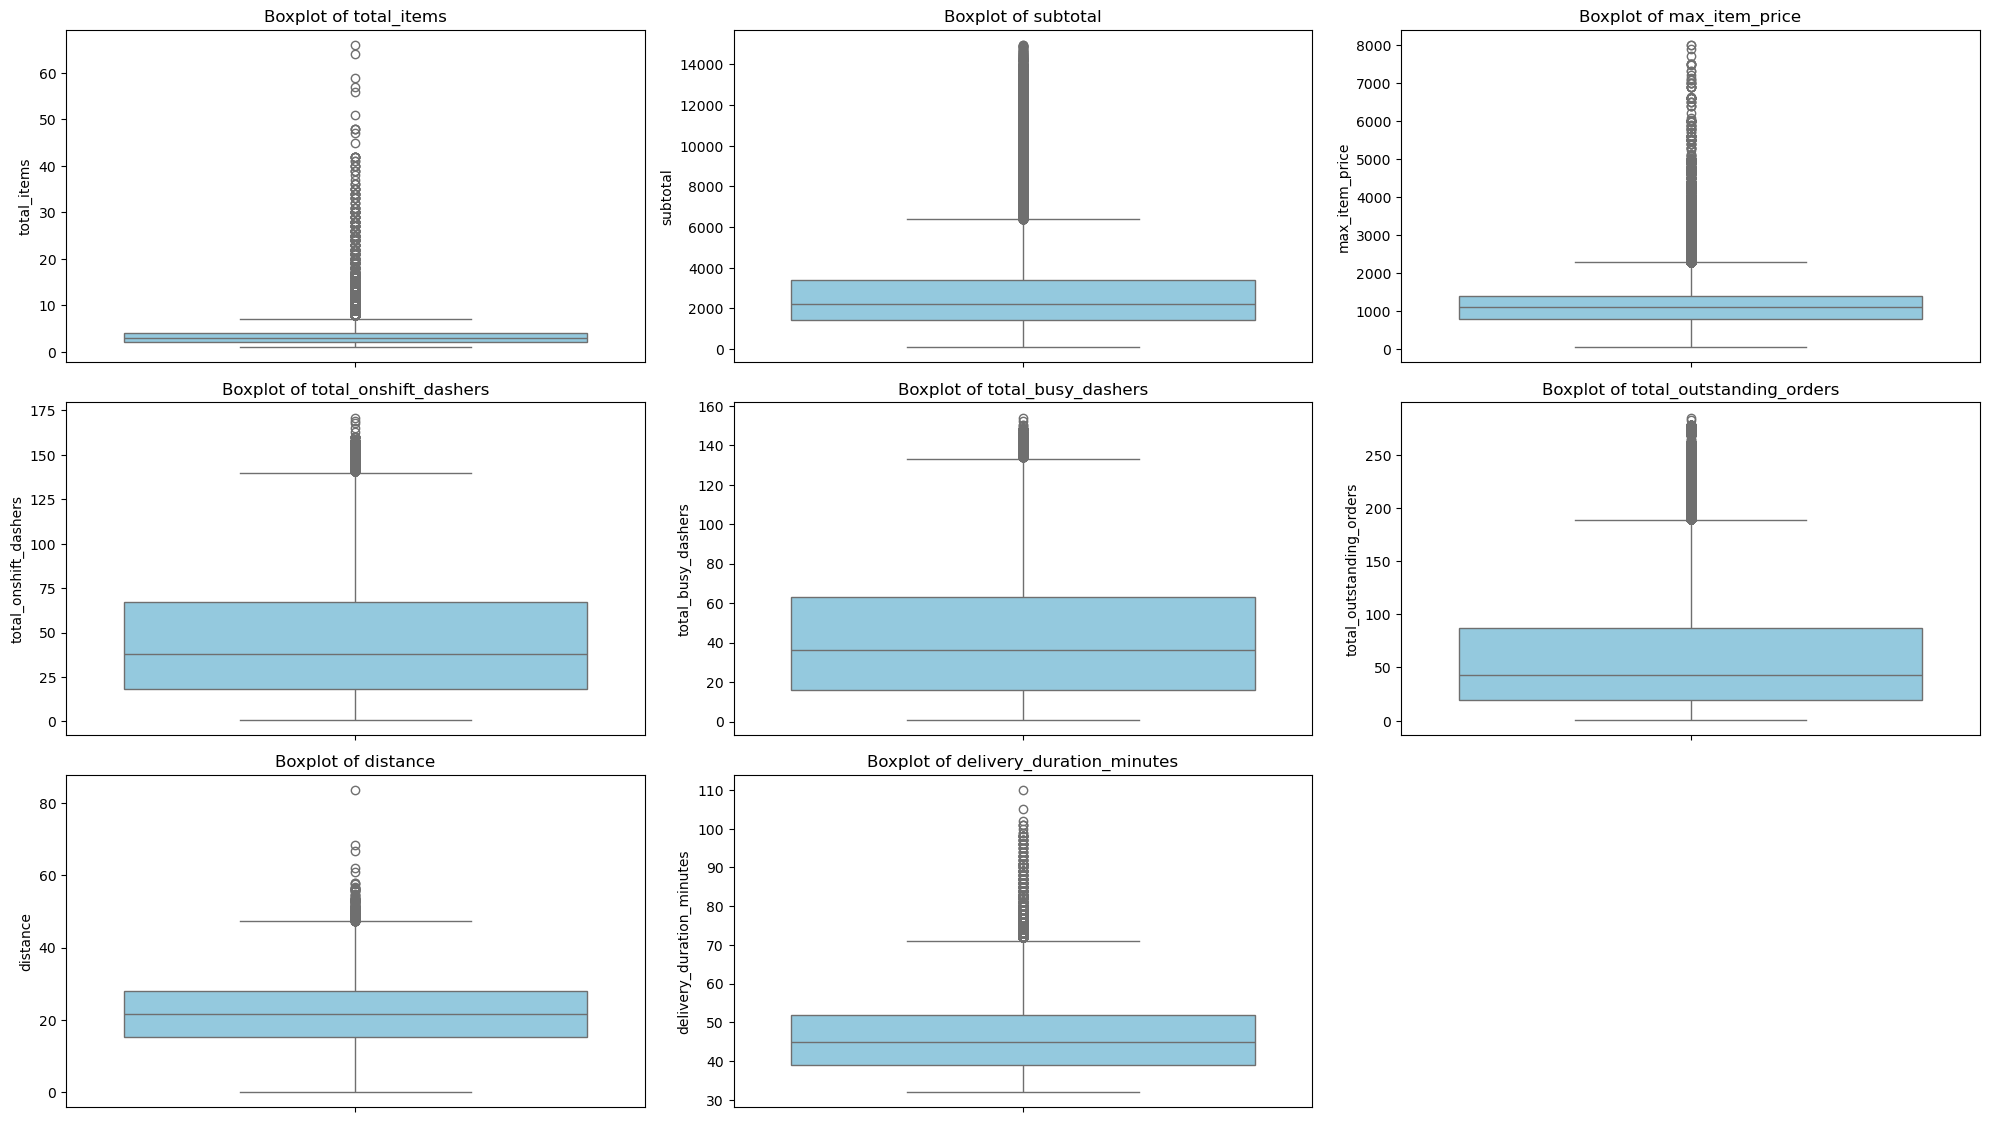

In [74]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(porter_train_cleaned_2[num_cols], 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=porter_train_cleaned_2[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [76]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [79]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [81]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [83]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [85]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [87]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [90]:
# Import libraries

# All libraries were imported in very first step

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [92]:
porter_train_cleaned_2.head()

store_primary_category order_protocol  total_items  subtotal  \
92179                      14            2.0            3      3600   
172804                     58            3.0            4      1458   
67246                      71            1.0            2      2590   
38049                      69            3.0            1      1050   
151202                      6            2.0            6      2875   

        max_item_price  total_onshift_dashers  total_busy_dashers  \
92179             1400                     40                  39   
172804             400                     38                  55   
67246             1295                     60                  60   
38049             1050                      2                   3   
151202             450                     61                  54   

        total_outstanding_orders  distance  delivery_duration_minutes  \
92179                         70     30.12                       59.0   
172804                        49     21.52                       37.0   
67246                         69     18.68                       43.0   
38049                          3     22.60                       41.0   
151202                        64     29.64                       40.0   

       created_hour created_is_weekend  
92179             3                  0  
172804           19                  0  
67246             3                  0  
38049            19                  0  
151202           21                  0

In [93]:
# Apply scaling to the numerical columns
# Instantiate an Object
scaler = MinMaxScaler()

# Create List of Numeric Variables required Normalisation
numvars = ['total_items', 'subtotal', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
           'total_outstanding_orders', 'distance', 'delivery_duration_minutes']

# Fit & Transform on the Train Data
porter_train_cleaned_2[numvars] = scaler.fit_transform(porter_train_cleaned_2[numvars])
porter_train_cleaned_2.head()


store_primary_category order_protocol  total_items  subtotal  \
92179                      14            2.0     0.030769  0.235611   
172804                     58            3.0     0.046154  0.091417   
67246                      71            1.0     0.015385  0.167620   
38049                      69            3.0     0.000000  0.063952   
151202                      6            2.0     0.076923  0.186806   

        max_item_price  total_onshift_dashers  total_busy_dashers  \
92179         0.169624               0.229412            0.248366   
172804        0.043790               0.217647            0.352941   
67246         0.156411               0.347059            0.385621   
38049         0.125582               0.005882            0.013072   
151202        0.050082               0.352941            0.346405   

        total_outstanding_orders  distance  delivery_duration_minutes  \
92179                   0.242958  0.359712                   0.346154   
172804                  0.169014  0.256595                   0.064103   
67246                   0.239437  0.222542                   0.141026   
38049                   0.007042  0.269544                   0.115385   
151202                  0.221831  0.353957                   0.102564   

       created_hour created_is_weekend  
92179             3                  0  
172804           19                  0  
67246             3                  0  
38049            19                  0  
151202           21                  0

In [103]:
# Convert the 'created_hour' categorical feature to 'hour_night'
porter_train_cleaned_2['hour_night'] = porter_train_cleaned_2['created_hour'].apply(lambda x: 1 if x in range(6,18) else 0).astype('category')

In [105]:
porter_train_cleaned_2.head()

store_primary_category order_protocol  total_items  subtotal  \
92179                      14            2.0     0.030769  0.235611   
172804                     58            3.0     0.046154  0.091417   
67246                      71            1.0     0.015385  0.167620   
38049                      69            3.0     0.000000  0.063952   
151202                      6            2.0     0.076923  0.186806   

        max_item_price  total_onshift_dashers  total_busy_dashers  \
92179         0.169624               0.229412            0.248366   
172804        0.043790               0.217647            0.352941   
67246         0.156411               0.347059            0.385621   
38049         0.125582               0.005882            0.013072   
151202        0.050082               0.352941            0.346405   

        total_outstanding_orders  distance  delivery_duration_minutes  \
92179                   0.242958  0.359712                   0.346154   
172804                  0.169014  0.256595                   0.064103   
67246                   0.239437  0.222542                   0.141026   
38049                   0.007042  0.269544                   0.115385   
151202                  0.221831  0.353957                   0.102564   

       created_hour created_is_weekend hour_night  
92179             3                  0          0  
172804           19                  0          0  
67246             3                  0          0  
38049            19                  0          0  
151202           21                  0          0

In [111]:
# Checking columns in updated dataframe
porter_train_cleaned_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136968 entries, 92179 to 145072
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   store_primary_category     136968 non-null  category
 1   order_protocol             136968 non-null  category
 2   total_items                136968 non-null  float64 
 3   subtotal                   136968 non-null  float64 
 4   max_item_price             136968 non-null  float64 
 5   total_onshift_dashers      136968 non-null  float64 
 6   total_busy_dashers         136968 non-null  float64 
 7   total_outstanding_orders   136968 non-null  float64 
 8   distance                   136968 non-null  float64 
 9   delivery_duration_minutes  136968 non-null  float64 
 10  created_is_weekend         136968 non-null  category
 11  hour_night                 136968 non-null  category
dtypes: category(4), float64(8)
memory usage: 9.9 MB


In [113]:
porter_train_cleaned_2['store_primary_category'].value_counts()

store_primary_category
4     14180
55    12359
46    12236
13     7767
58     7038
      ...  
56        6
43        6
8         2
3         1
21        1
Name: count, Length: 73, dtype: int64

In [115]:
porter_train_cleaned_2['order_protocol'].value_counts()

order_protocol
1.0    37400
3.0    36931
5.0    32490
2.0    16440
4.0    13272
6.0      422
7.0       13
Name: count, dtype: int64

In [117]:
# Group by store_primary_category and compute mean of target variable
mean_map = porter_train_cleaned_2.groupby('store_primary_category')['delivery_duration_minutes'].mean()

# Map the mean to the original dataframe
porter_train_cleaned_2['store_category_encoded'] = porter_train_cleaned_2['store_primary_category'].map(mean_map)


In [119]:
# Compute mean delivery duration per order_protocol
mean_protocol_duration = porter_train_cleaned_2.groupby('order_protocol')['delivery_duration_minutes'].mean()

# Map those means as encoded values
porter_train_cleaned_2['order_protocol_encoded'] = porter_train_cleaned_2['order_protocol'].map(mean_protocol_duration)


In [121]:
porter_train_cleaned_2.head()

store_primary_category order_protocol  total_items  subtotal  \
92179                      14            2.0     0.030769  0.235611   
172804                     58            3.0     0.046154  0.091417   
67246                      71            1.0     0.015385  0.167620   
38049                      69            3.0     0.000000  0.063952   
151202                      6            2.0     0.076923  0.186806   

        max_item_price  total_onshift_dashers  total_busy_dashers  \
92179         0.169624               0.229412            0.248366   
172804        0.043790               0.217647            0.352941   
67246         0.156411               0.347059            0.385621   
38049         0.125582               0.005882            0.013072   
151202        0.050082               0.352941            0.346405   

        total_outstanding_orders  distance  delivery_duration_minutes  \
92179                   0.242958  0.359712                   0.346154   
172804                  0.169014  0.256595                   0.064103   
67246                   0.239437  0.222542                   0.141026   
38049                   0.007042  0.269544                   0.115385   
151202                  0.221831  0.353957                   0.102564   

       created_is_weekend hour_night store_category_encoded  \
92179                   0          0               0.229113   
172804                  0          0               0.137470   
67246                   0          0               0.198256   
38049                   0          0               0.188755   
151202                  0          0               0.180349   

       order_protocol_encoded  
92179                0.187938  
172804               0.186761  
67246                0.202547  
38049                0.186761  
151202               0.187938

In [127]:
porter_train_cleaned_final = porter_train_cleaned_2.drop(['order_protocol', 'store_primary_category', 'created_hour'], axis=1, inplace=False)
porter_train_cleaned_final.head()

total_items  subtotal  max_item_price  total_onshift_dashers  \
92179      0.030769  0.235611        0.169624               0.229412   
172804     0.046154  0.091417        0.043790               0.217647   
67246      0.015385  0.167620        0.156411               0.347059   
38049      0.000000  0.063952        0.125582               0.005882   
151202     0.076923  0.186806        0.050082               0.352941   

        total_busy_dashers  total_outstanding_orders  distance  \
92179             0.248366                  0.242958  0.359712   
172804            0.352941                  0.169014  0.256595   
67246             0.385621                  0.239437  0.222542   
38049             0.013072                  0.007042  0.269544   
151202            0.346405                  0.221831  0.353957   

        delivery_duration_minutes created_is_weekend hour_night  \
92179                    0.346154                  0          0   
172804                   0.064103                  0          0   
67246                    0.141026                  0          0   
38049                    0.115385                  0          0   
151202                   0.102564                  0          0   

       store_category_encoded order_protocol_encoded  
92179                0.229113               0.187938  
172804               0.137470               0.186761  
67246                0.198256               0.202547  
38049                0.188755               0.186761  
151202               0.180349               0.187938

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [129]:
# Create/Initialise the model
y_train = porter_train_cleaned_final.pop('delivery_duration_minutes')
X_train = porter_train_cleaned_final

In [131]:
# Train the model using the training data
X_train_sm = sm.add_constant(X_train)
X_train_sm.head()

const  total_items  subtotal  max_item_price  total_onshift_dashers  \
92179     1.0     0.030769  0.235611        0.169624               0.229412   
172804    1.0     0.046154  0.091417        0.043790               0.217647   
67246     1.0     0.015385  0.167620        0.156411               0.347059   
38049     1.0     0.000000  0.063952        0.125582               0.005882   
151202    1.0     0.076923  0.186806        0.050082               0.352941   

        total_busy_dashers  total_outstanding_orders  distance  \
92179             0.248366                  0.242958  0.359712   
172804            0.352941                  0.169014  0.256595   
67246             0.385621                  0.239437  0.222542   
38049             0.013072                  0.007042  0.269544   
151202            0.346405                  0.221831  0.353957   

       created_is_weekend hour_night store_category_encoded  \
92179                   0          0               0.229113   
172804                  0          0               0.137470   
67246                   0          0               0.198256   
38049                   0          0               0.188755   
151202                  0          0               0.180349   

       order_protocol_encoded  
92179                0.187938  
172804               0.186761  
67246                0.202547  
38049                0.186761  
151202               0.187938

In [133]:
# Make predictions

# Create the Updated Model & Fit
lr = sm.OLS(y_train, X_train_sm).fit()

In [135]:
# Find results for evaluation metrics
# Check the Updated Model Parameters
print(lr.params)

# Check the Summary
print(lr.summary())

const                      -0.147843
total_items                 0.179593
subtotal                    0.278031
max_item_price              0.075536
total_onshift_dashers      -0.746035
total_busy_dashers         -0.285863
total_outstanding_orders    1.275125
distance                    0.505047
created_is_weekend          0.014325
hour_night                 -0.007359
store_category_encoded      0.162191
order_protocol_encoded      0.609101
dtype: float64
                                OLS Regression Results                               
Dep. Variable:     delivery_duration_minutes   R-squared:                       0.827
Model:                                   OLS   Adj. R-squared:                  0.827
Method:                        Least Squares   F-statistic:                 5.947e+04
Date:                       Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                               10:30:58   Log-Likelihood:             2.1645e+05
No. Observations:        

In [137]:
# Creating a dataframe with all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

Features    VIF
9     store_category_encoded  51.62
10    order_protocol_encoded  47.73
3      total_onshift_dashers  30.86
4         total_busy_dashers  29.22
5   total_outstanding_orders  21.63
2             max_item_price   9.43
1                   subtotal   8.62
6                   distance   7.02
0                total_items   3.65
7         created_is_weekend   1.57
8                 hour_night   1.10

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [162]:
# Loop through the number of features and test the model

# Running RFE with the Output Number of Variables Equals to 10

#Fit the Model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Pass the Model to RFE
rfe = RFE(estimator=lm, n_features_to_select=11)
rfe = rfe.fit(X_train, y_train)

In [164]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('total_items', True, 1),
 ('subtotal', True, 1),
 ('max_item_price', True, 1),
 ('total_onshift_dashers', True, 1),
 ('total_busy_dashers', True, 1),
 ('total_outstanding_orders', True, 1),
 ('distance', True, 1),
 ('created_is_weekend', True, 1),
 ('hour_night', True, 1),
 ('store_category_encoded', True, 1),
 ('order_protocol_encoded', True, 1)]

In [166]:
col = X_train.columns[rfe.support_]
col

Index(['total_items', 'subtotal', 'max_item_price', 'total_onshift_dashers',
       'total_busy_dashers', 'total_outstanding_orders', 'distance',
       'created_is_weekend', 'hour_night', 'store_category_encoded',
       'order_protocol_encoded'],
      dtype='object')

In [168]:
# Creating X_Train DF with Features selected by RFE
X_train_rfe = X_train[col]

# Adding Constant to DF
X_train_rfe_sm = sm.add_constant(X_train_rfe)

# Create the Updated Model & Fit
lr_rfe = sm.OLS(y_train, X_train_rfe_sm).fit()

# Check the Updated Model Parameters
print(lr_rfe.params)

# Check the Summary
print(lr_rfe.summary())

const                      -0.147843
total_items                 0.179593
subtotal                    0.278031
max_item_price              0.075536
total_onshift_dashers      -0.746035
total_busy_dashers         -0.285863
total_outstanding_orders    1.275125
distance                    0.505047
created_is_weekend          0.014325
hour_night                 -0.007359
store_category_encoded      0.162191
order_protocol_encoded      0.609101
dtype: float64
                                OLS Regression Results                               
Dep. Variable:     delivery_duration_minutes   R-squared:                       0.827
Model:                                   OLS   Adj. R-squared:                  0.827
Method:                        Least Squares   F-statistic:                 5.947e+04
Date:                       Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                               12:20:29   Log-Likelihood:             2.1645e+05
No. Observations:        

In [170]:
# Creating a dataframe with updated feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

Features    VIF
9     store_category_encoded  51.62
10    order_protocol_encoded  47.73
3      total_onshift_dashers  30.86
4         total_busy_dashers  29.22
5   total_outstanding_orders  21.63
2             max_item_price   9.43
1                   subtotal   8.62
6                   distance   7.02
0                total_items   3.65
7         created_is_weekend   1.57
8                 hour_night   1.10

In [194]:
# Updated DF
X_train_rfe_2 = X_train_rfe.drop('store_category_encoded', axis = 1)

# Add Constant to Updated DF
X_train_rfe_sm_2 = sm.add_constant(X_train_rfe_2)

# Create the Updated Model & Fit
lr_rfe_2 = sm.OLS(y_train, X_train_rfe_sm_2).fit()

# Check the Updated Model Parameters
print(lr_rfe_2.params)

# Check the Summary
print(lr_rfe_2.summary())

const                      -0.127456
total_items                 0.169743
subtotal                    0.284026
max_item_price              0.085759
total_onshift_dashers      -0.745551
total_busy_dashers         -0.285954
total_outstanding_orders    1.276702
distance                    0.505910
created_is_weekend          0.014336
hour_night                 -0.008994
order_protocol_encoded      0.643436
dtype: float64
                                OLS Regression Results                               
Dep. Variable:     delivery_duration_minutes   R-squared:                       0.826
Model:                                   OLS   Adj. R-squared:                  0.826
Method:                        Least Squares   F-statistic:                 6.501e+04
Date:                       Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                               12:25:38   Log-Likelihood:             2.1609e+05
No. Observations:                     136968   AIC:           

In [196]:
# Creating a dataframe with updated feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_2.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_2.values, i) for i in range(X_train_rfe_2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

Features    VIF
3     total_onshift_dashers  30.82
4        total_busy_dashers  29.19
5  total_outstanding_orders  21.63
9    order_protocol_encoded  12.63
2            max_item_price   9.15
1                  subtotal   8.61
6                  distance   6.90
0               total_items   3.65
7        created_is_weekend   1.57
8                hour_night   1.10

**Though the features *'total_onshift_dashers'* & *'total_outstanding_orders'* are having highest VIF, droping this is resulting for drastic reduction in R-squared value hence proceeding with the next highest one**

In [198]:
# Updated DF
X_train_rfe_3 = X_train_rfe_2.drop('total_busy_dashers', axis = 1)

# Add Constant to Updated DF
X_train_rfe_sm_3 = sm.add_constant(X_train_rfe_3)

# Create the Updated Model & Fit
lr_rfe_3 = sm.OLS(y_train, X_train_rfe_sm_3).fit()

# Check the Updated Model Parameters
print(lr_rfe_3.params)

# Check the Summary
print(lr_rfe_3.summary())

const                      -0.139283
total_items                 0.176539
subtotal                    0.284114
max_item_price              0.083248
total_onshift_dashers      -0.910738
total_outstanding_orders    1.146663
distance                    0.504231
created_is_weekend          0.012679
hour_night                 -0.004587
order_protocol_encoded      0.671654
dtype: float64
                                OLS Regression Results                               
Dep. Variable:     delivery_duration_minutes   R-squared:                       0.803
Model:                                   OLS   Adj. R-squared:                  0.803
Method:                        Least Squares   F-statistic:                 6.200e+04
Date:                       Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                               12:26:07   Log-Likelihood:             2.0757e+05
No. Observations:                     136968   AIC:                        -4.151e+05
Df Residuals:

In [200]:
# Creating a dataframe with updated feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_3.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_3.values, i) for i in range(X_train_rfe_3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

Features    VIF
3     total_onshift_dashers  21.51
4  total_outstanding_orders  17.75
8    order_protocol_encoded  12.55
2            max_item_price   9.15
1                  subtotal   8.61
5                  distance   6.90
0               total_items   3.65
6        created_is_weekend   1.57
7                hour_night   1.09

**Though the features *'total_onshift_dashers'* & *'total_outstanding_orders'* are having highest VIF, droping this is resulting for drastic reduction in R-squared value hence proceeding with the next highest one**

In [217]:
# Updated DF
X_train_rfe_4 = X_train_rfe_3.drop('order_protocol_encoded', axis = 1)

# Add Constant to Updated DF
X_train_rfe_sm_4 = sm.add_constant(X_train_rfe_4)

# Create the Updated Model & Fit
lr_rfe_4 = sm.OLS(y_train, X_train_rfe_sm_4).fit()

# Check the Updated Model Parameters
print(lr_rfe_4.params)

# Check the Summary
print(lr_rfe_4.summary())

const                      -0.020868
total_items                 0.128566
subtotal                    0.302055
max_item_price              0.101117
total_onshift_dashers      -0.917902
total_outstanding_orders    1.147834
distance                    0.507352
created_is_weekend          0.012648
hour_night                 -0.006194
dtype: float64
                                OLS Regression Results                               
Dep. Variable:     delivery_duration_minutes   R-squared:                       0.792
Model:                                   OLS   Adj. R-squared:                  0.792
Method:                        Least Squares   F-statistic:                 6.509e+04
Date:                       Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                               12:33:25   Log-Likelihood:             2.0379e+05
No. Observations:                     136968   AIC:                        -4.076e+05
Df Residuals:                         136959   BIC

In [219]:
# Creating a dataframe with updated feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_4.values, i) for i in range(X_train_rfe_4.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

Features    VIF
3     total_onshift_dashers  20.87
4  total_outstanding_orders  17.58
1                  subtotal   8.56
2            max_item_price   7.28
5                  distance   4.19
0               total_items   3.48
6        created_is_weekend   1.54
7                hour_night   1.07

**Further removing any variable considering the higher VIF, is resulting to reduction in R-Squared value. Hence will be considering this model as final with 0.803 R-squared value and 8 feature variables**

In [221]:
# Build the final model with selected number of features
print(lr_rfe_4.summary())

                                OLS Regression Results                               
Dep. Variable:     delivery_duration_minutes   R-squared:                       0.792
Model:                                   OLS   Adj. R-squared:                  0.792
Method:                        Least Squares   F-statistic:                 6.509e+04
Date:                       Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                               12:37:35   Log-Likelihood:             2.0379e+05
No. Observations:                     136968   AIC:                        -4.076e+05
Df Residuals:                         136959   BIC:                        -4.075e+05
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

#### Equation of the Final Model

$ delivery\_duration\_minutes = - 0.021 + (0.129  \times  total\_items) + (0.302  \times  subtotal) + (0.101 \times max\_item\_price) - (0.918 \times total\_onshift\_dashers) + $
$ (1.148 \times total\_outstanding\_orders) + (0.508 \times distance) + (0.013 \times created\_is\_weekend) + (0.006 \times hour\_night) $

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

[Your inferences here:]



In [228]:
# Computing the predicted of y_train for Latest Model
y_train_rfe_pred = lr_rfe_4.predict(X_train_rfe_sm_4)
y_train_rfe_pred.head()

92179     0.322205
172804    0.141512
67246     0.116731
38049     0.150585
151202    0.160752
dtype: float64

In [230]:
# Computing the Residual Values
res = y_train - y_train_rfe_pred
res.head()

92179     0.023948
172804   -0.077409
67246     0.024295
38049    -0.035200
151202   -0.058188
dtype: float64

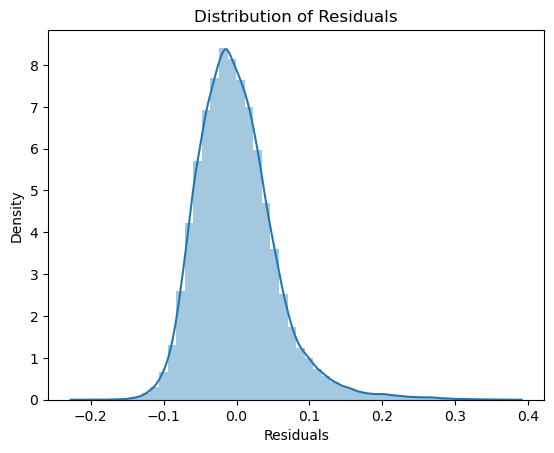

In [232]:
# Plotting Histogram of Residual Values
sns.distplot(res)
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Distribution of Residuals")
plt.show()

I began by plotting the distribution of residuals. The histogram looked quite bell-shaped and symmetric around zero, with a smooth peak and tapered ends. Although it was slightly peaked and a bit right-skewed, it was still reasonably close to a normal distribution.

To me, this confirms that the model's errors are largely random and centered around the true values—which is a very encouraging sign. This reassures me that the regression isn’t consistently over- or under-predicting delivery times.

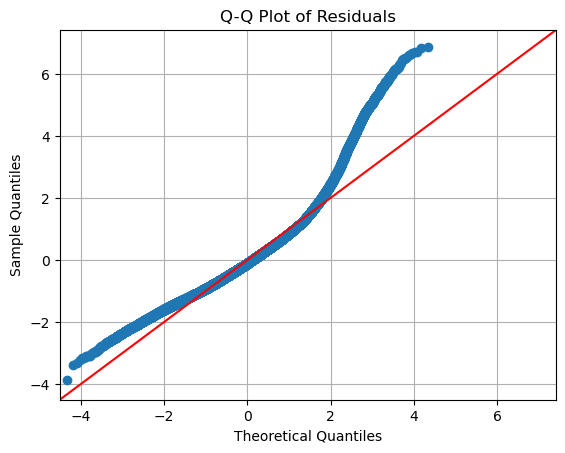

In [234]:
sm.qqplot(res, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

Next, I checked the Q-Q plot to assess whether residuals follow a normal distribution across all quantiles. Most of the data points hugged the red reference line quite closely in the middle. There were some deviations at both ends (fat tails), but this is quite common in real-world datasets, especially large ones.

What matters is that the bulk of residuals stayed aligned with the theoretical quantiles, showing that the core distribution behaves normally, even if a few extremes deviate. I interpret this as acceptable, especially considering the dataset size (~137K records).

Putting both plots together, I believe the model residuals show no serious violations of linear regression assumptions. Some tail deviation is present, but not severe enough to invalidate results. In fact, these results align very well with the high R-squared value of 0.792, which confirms that the model explains 79.2% of the variance in delivery time.

Even the Durbin-Watson statistic of ~2 indicates no autocorrelation in residuals, and all predictors are highly significant (p-values < 0.001). The model is clearly stable and statistically sound.

#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model


**Scaled Features**
+ **total_outstanding_orders** is having the highest postivie impact on the final model
+ **total_onshift_dashers** is having the highest negative impact on the final model
+ **distance** is also having a good amount of positive impact
+ Other features like **subtotal**, **total_items** and **max_item_pricing** are having low positive impact in comparision to the above

**Un-scaled Features**
+ **created_hour** is having a moderate positive impact
+ **created_is_weekend** is having a low positive impact


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'


**total_items (0.129)**:

- Delivery time increases by 0.13 minutes for every additional item.

**subtotal (0.302)**:

- Delivery time increases by 0.30 minutes for every ₹1 increase in subtotal.

**max_item_price (0.101)**:

- Higher-priced items increase delivery time by 0.10 minutes per ₹1.

**total_onshift_dashers (-0.918)**:

- Delivery time decreases by 0.92 minutes with each additional dasher on shift.

**total_outstanding_orders (1.148)**:

- Delivery time increases by 1.15 minutes for every additional active order.

**distance (0.508)**:

- Delivery time increases by 0.51 minutes per kilometer of distance.

**created_is_weekend (0.013)**:

- Deliveries on weekends take 0.01 minutes longer on average.

**hour_night (0.006)**:

- Deliveries on nights take 0.01 minutes longer on average.

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> Yes, **two**: **store_primary_category** and **order_protocol**.

> **store_primary_category** slightly increases delivery time.

> **order_protocol** has a negative coefficient, meaning some protocols speed up delivery.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
When I used test_size = 0.2 during the train-test split, I was essentially reserving 20% of the total dataset for testing the model's performance, while using the remaining 80% for training. This allowed me to evaluate how well the model would generalize to unseen data, which is crucial for validating the robustness of any predictive model.

> It means 20% of the data is used for **testing** and 80% for training.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
From the heatmap I generated during exploratory data analysis, the variable that stood out with the highest positive correlation to delivery_duration_minutes was distance. This makes intuitive sense to me—longer distances naturally lead to longer delivery times. The visual representation clearly confirmed this strong linear relationship.

> From the heatmap, **distance** shows the highest positive correlation with delivery time.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**
I started by visually inspecting the distributions and box plots of all numerical features, which immediately revealed the presence of extreme values. To deepen the analysis, I also generated an extended 7-point summary including the 90th and 95th percentiles. This helped me distinguish between natural spread and true outliers. 

I found that several features had suspiciously low (even negative or zero) values, especially in variables like subtotal, max_item_price, and total_busy_dashers. I treated such values as invalid and removed them outright. For high-end outliers, I used IQR-based capping on selected variables like max_item_price and total_items to contain their influence without compromising the integrity of the data.


> I used the IQR method.
> 
> Focused on key variables like **max_item_price**, **total_items**, and **subtotal**.
> 
> Removed extreme records (~2.6% of data) to improve model quality.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
Looking at the final OLS regression results, the top three features with the most significant impact on delivery time were:

> 1. **distance** — increases time significantly.
> 
> 2. **total_outstanding_orders** — strong positive impact.
> 
> 3. **total_onshift_dashers** — more dashers reduce delivery time.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
Linear regression is one of the simplest yet powerful algorithms I worked with. It tries to establish a linear relationship between the input features and the target variable by fitting a straight line (or a hyperplane in multiple dimensions) through the data points. The model assumes the relationship can be represented as:

y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε
where β₀ is the intercept, β₁...βₙ are coefficients, and ε is the error term.

The model learns the coefficients by minimizing the cost function—usually the Mean Squared Error (MSE)—which measures how far the predicted values are from the actual ones. Once fitted, the model can predict outcomes for new data and we can interpret coefficients to understand the influence of each feature on the target. It’s simple, interpretable, and works really well when the linearity assumption holds.


>Predicts a target using a straight-line equation.
>
>Fits the line by minimizing error (usually using MSE).
>
>It’s fast, interpretable, and forms the basis for many models.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
In my learning, I understood that simple linear regression deals with just one independent variable predicting the target.

Whereas the multiple linear regression includes two or more features. For instance, predicting delivery time based on only distance would be simple linear regression. But if I include other variables like subtotal, order_protocol, and total_items, it becomes a multiple linear regression. The core algorithm remains the same, but with multiple inputs, the model captures more complexity and interactions.

> Simple Linear Regression: one feature, one target.
> 
> Multiple Linear Regression: many features predicting one target.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
The cost function, especially Mean Squared Error (MSE), plays a central role in linear regression. It quantifies how well the predicted values match the actual target values. The goal of the model is to minimize this error. 

I used the least squares method to find the best-fitting line by adjusting the model's coefficients. This process involves calculating the partial derivatives of the cost function with respect to each parameter and then updating them using optimization techniques like Gradient Descent (though in my case, I used analytical solutions via OLS). The lower the cost, the better the model fits.

> It measures prediction error.
> 
> Commonly used: Mean Squared Error.
> 
> Optimized using techniques like Gradient Descent.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**
In my model building process, I was always cautious of overfitting and underfitting. Overfitting happens when the model learns even the noise in the training data, performing well there but failing on unseen data. It’s like memorizing the answers without understanding.

Underfitting, on the other hand, is when the model is too simple and doesn’t capture the data’s real patterns—leading to poor performance across both training and testing sets. I aimed to strike a balance by using the right number of features and validating the model carefully.

> Overfitting: model memorizes noise → poor generalization.
> 
> Underfitting: model too simple → poor on both train and test.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
Residual plots were really helpful for me in understanding the quality of my regression model. By plotting the residuals (i.e., the differences between actual and predicted values), I could visually inspect whether the model’s assumptions held true. Ideally, residuals should be randomly scattered around zero. 

In my case, a good residual plot confirmed that linearity was a reasonable assumption and variance was roughly constant. But any patterns—like curves or funnels—would have signaled problems like non-linearity or heteroscedasticity. So, it’s a great diagnostic tool for verifying the trustworthiness of a regression fit.

> Shows how actual vs predicted values differ.
> 
> Random spread = good fit.
> 
> Patterns = something wrong (non-linearity, heteroscedasticity).